Goal: Goal: Train and test a Random Forest Regression model using features: Bednights, Region, HHSize, HHEmployed, HHTANF, and slotted along with group: FamilyID to be able to predict bednights. Evaluate and iterate model. Second attempt at modeling after Linear Regression.

In [14]:
##Load Modules for Roandom Forest Regression Analysis training and testing
import pandas as pd
from sklearn.model_selection import GridSearchCV, GroupKFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy as np

In [3]:
##Load data, already processed to show no duplicates and no NaN in Linear Model, won't be repeated here
##Forest Regressor handles one-hot encoding natively, won't repeat pd.get_dummies here.
## descriptive statistics handled previously in Linear Regression. .describe() not repeated here.
forest1 = pd.read_csv("C:/Users/morel/Downloads/Training Data 7-4-2025.csv")
forest1['HHSize_bin'] = pd.cut(forest1['HHSize'], bins=[0,4,10], labels=['small','big'])
print(forest1.head(5))

   FamilyID  ResidentID  Bednights  RegionCode  HHSize  HHEmployed  HHTANF  \
0       243         957        957           1       4           1       0   
1       243         958        957           1       4           1       0   
2       243         959        957           1       4           1       0   
3       243         960        957           1       4           1       0   
4       242         973        944           1       3           1       0   

   Slotted  SlottedCCM  SlottedPME  Destination  SingleMom  SingleDad  \
0        0           0           0            6          0          0   
1        0           0           0            6          0          0   
2        0           0           0            6          1          0   
3        0           0           0            6          0          0   
4        1           1           0            4          0          0   

   SingleParent  Disability HHSize_bin  
0             0           0      small  
1         

In [4]:
##Forest Regression: predict bednights. expand categorical column
forest_encoded = pd.get_dummies(forest1, columns=['RegionCode','Destination','HHSize_bin'], dtype=int)
x = forest_encoded.drop(columns=['Bednights','FamilyID','ResidentID','Destination_1']) 
y = forest_encoded['Bednights']                                       
groups = forest_encoded['FamilyID']
print(forest_encoded.head())

   FamilyID  ResidentID  Bednights  HHSize  HHEmployed  HHTANF  Slotted  \
0       243         957        957       4           1       0        0   
1       243         958        957       4           1       0        0   
2       243         959        957       4           1       0        0   
3       243         960        957       4           1       0        0   
4       242         973        944       3           1       0        1   

   SlottedCCM  SlottedPME  SingleMom  ...  Destination_4  Destination_5  \
0           0           0          0  ...              0              0   
1           0           0          0  ...              0              0   
2           0           0          1  ...              0              0   
3           0           0          0  ...              0              0   
4           1           0          0  ...              1              0   

   Destination_6  Destination_7  Destination_8  Destination_9  Destination_10  \
0              1 

HHSize: 0.1208
HHEmployed: 0.2848
HHTANF: 0.0495
Slotted: 0.0239
SlottedCCM: 0.0160
SlottedPME: 0.0172
SingleMom: 0.0072
SingleDad: 0.0116
SingleParent: 0.0050
Disability: 0.0035
RegionCode_1: 0.0171
RegionCode_2: 0.0137
RegionCode_3: 0.0156
RegionCode_4: 0.0200
RegionCode_5: 0.0000
Destination_2: 0.0006
Destination_3: 0.1244
Destination_4: 0.0432
Destination_5: 0.0405
Destination_6: 0.0482
Destination_7: 0.0113
Destination_8: 0.0130
Destination_9: 0.0114
Destination_10: 0.0273
Destination_11: 0.0221
HHSize_bin_small: 0.0299
HHSize_bin_big: 0.0222


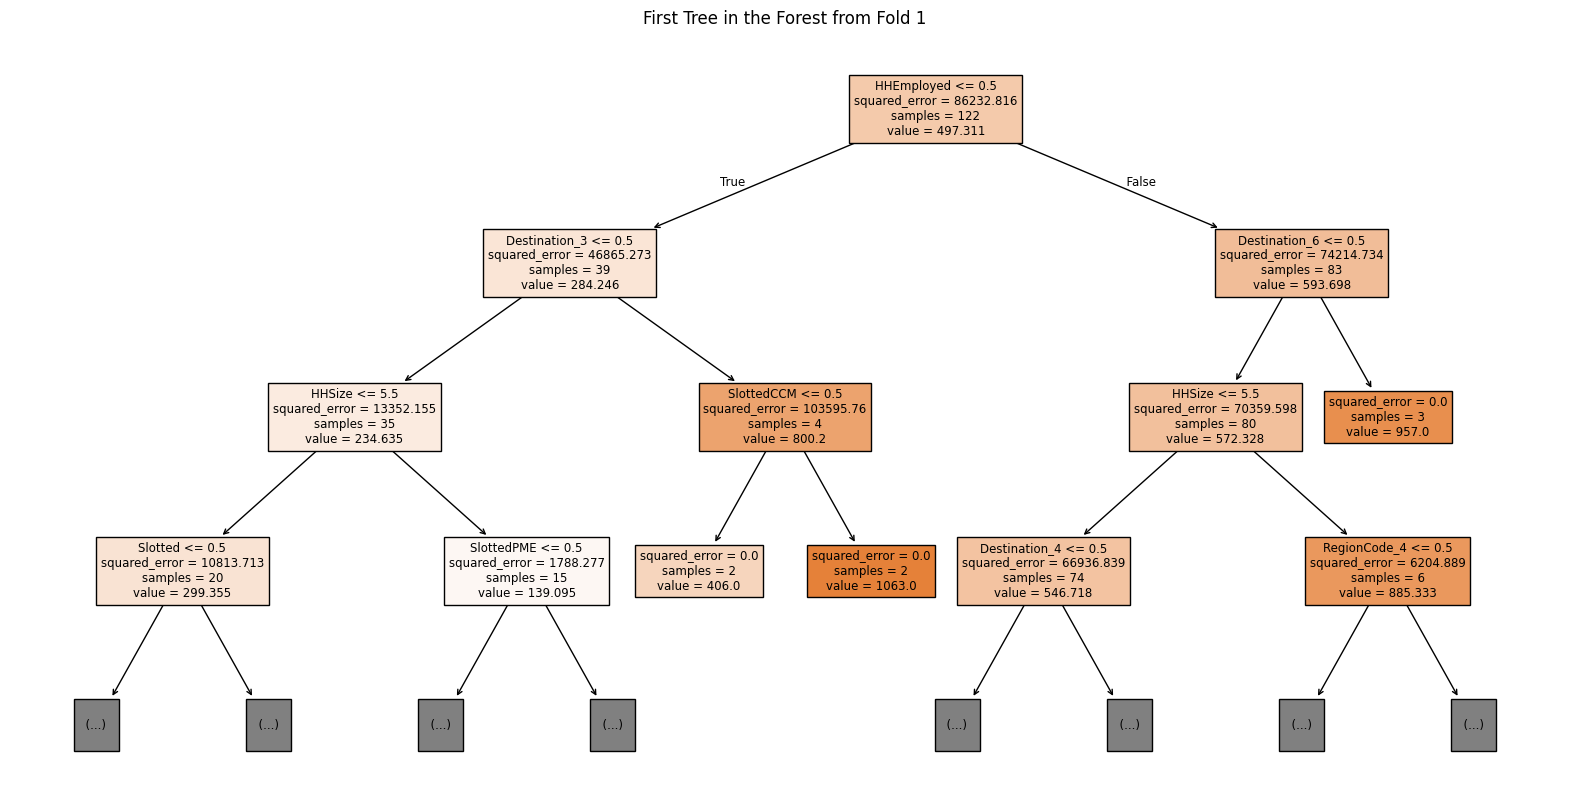

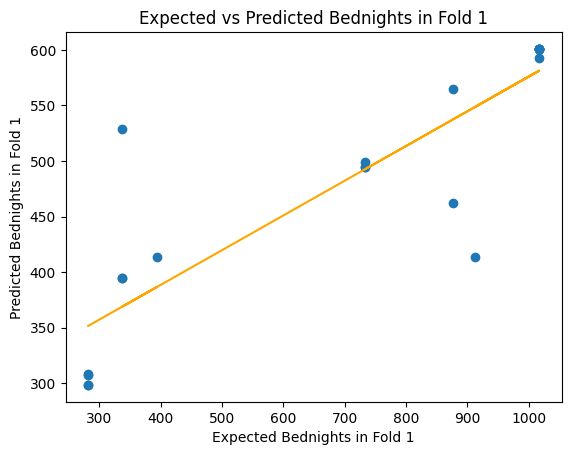

Fold 1 - MSE: 92948.1963, RMSE: 304.8741, R^2: 0.0245
HHSize: 0.1990
HHEmployed: 0.2572
HHTANF: 0.0412
Slotted: 0.0189
SlottedCCM: 0.0256
SlottedPME: 0.0151
SingleMom: 0.0118
SingleDad: 0.0050
SingleParent: 0.0049
Disability: 0.0009
RegionCode_1: 0.0263
RegionCode_2: 0.0158
RegionCode_3: 0.0129
RegionCode_4: 0.0270
RegionCode_5: 0.0002
Destination_2: 0.0002
Destination_3: 0.1082
Destination_4: 0.0382
Destination_5: 0.0282
Destination_6: 0.0417
Destination_7: 0.0040
Destination_8: 0.0185
Destination_9: 0.0131
Destination_10: 0.0259
Destination_11: 0.0219
HHSize_bin_small: 0.0181
HHSize_bin_big: 0.0201


<Figure size 640x480 with 0 Axes>

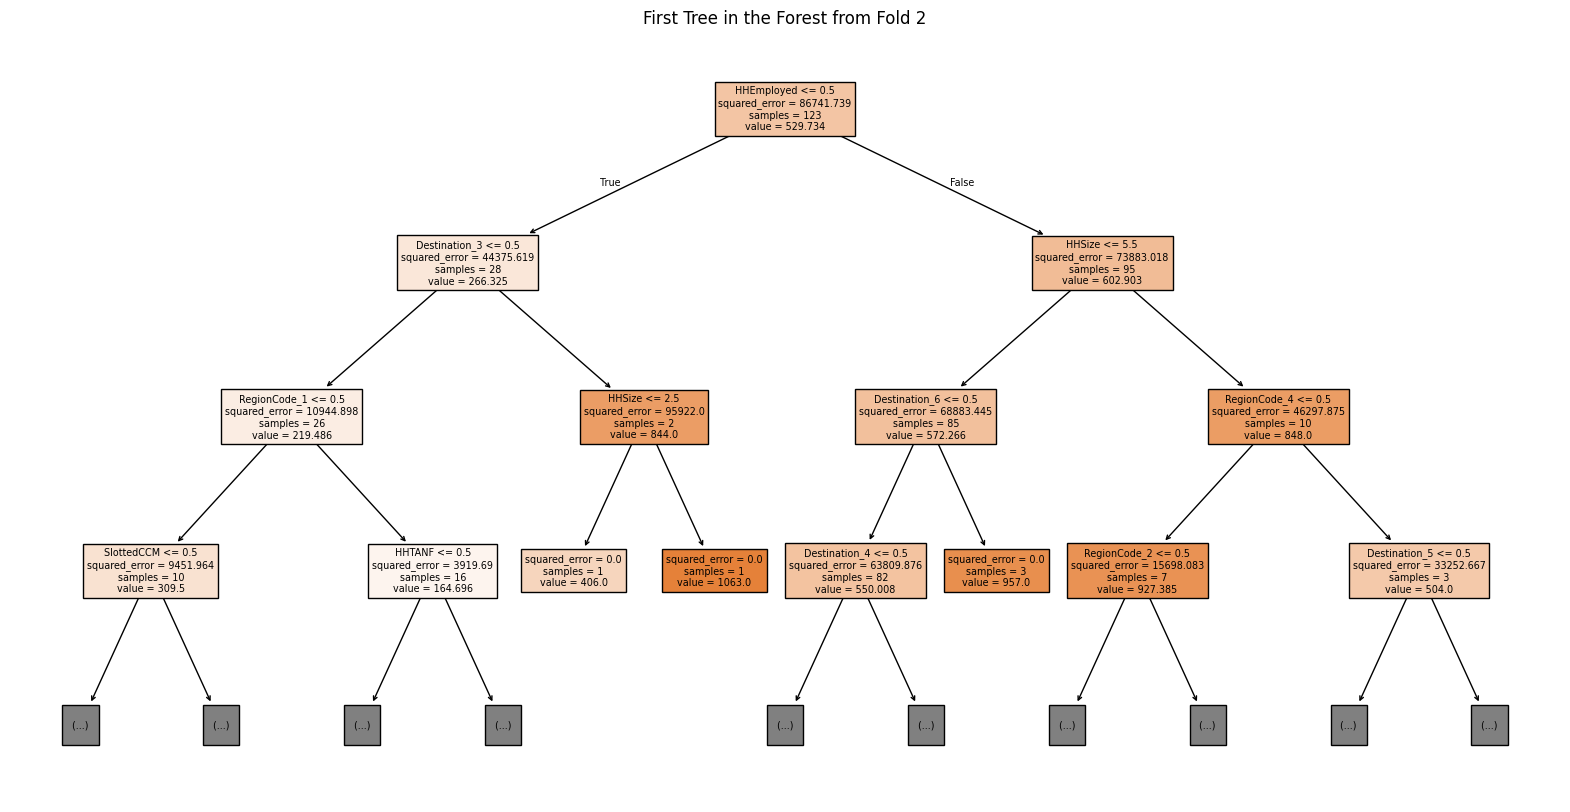

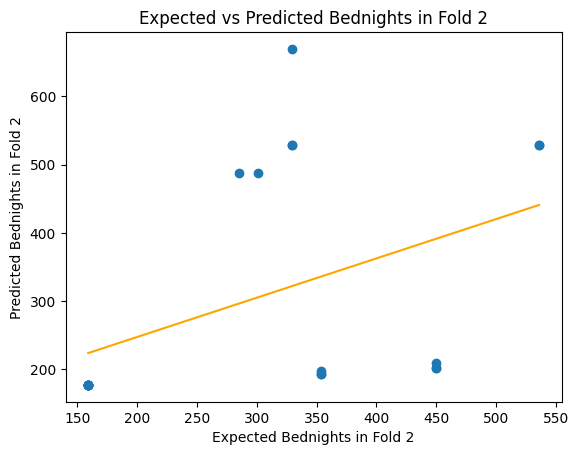

Fold 2 - MSE: 26635.9266, RMSE: 163.2052, R^2: -0.6236
HHSize: 0.1978
HHEmployed: 0.2481
HHTANF: 0.0518
Slotted: 0.0327
SlottedCCM: 0.0274
SlottedPME: 0.0151
SingleMom: 0.0055
SingleDad: 0.0025
SingleParent: 0.0051
Disability: 0.0023
RegionCode_1: 0.0169
RegionCode_2: 0.0147
RegionCode_3: 0.0068
RegionCode_4: 0.0339
RegionCode_5: 0.0000
Destination_2: 0.0004
Destination_3: 0.1024
Destination_4: 0.0418
Destination_5: 0.0332
Destination_6: 0.0447
Destination_7: 0.0038
Destination_8: 0.0140
Destination_9: 0.0118
Destination_10: 0.0238
Destination_11: 0.0244
HHSize_bin_small: 0.0170
HHSize_bin_big: 0.0223


<Figure size 640x480 with 0 Axes>

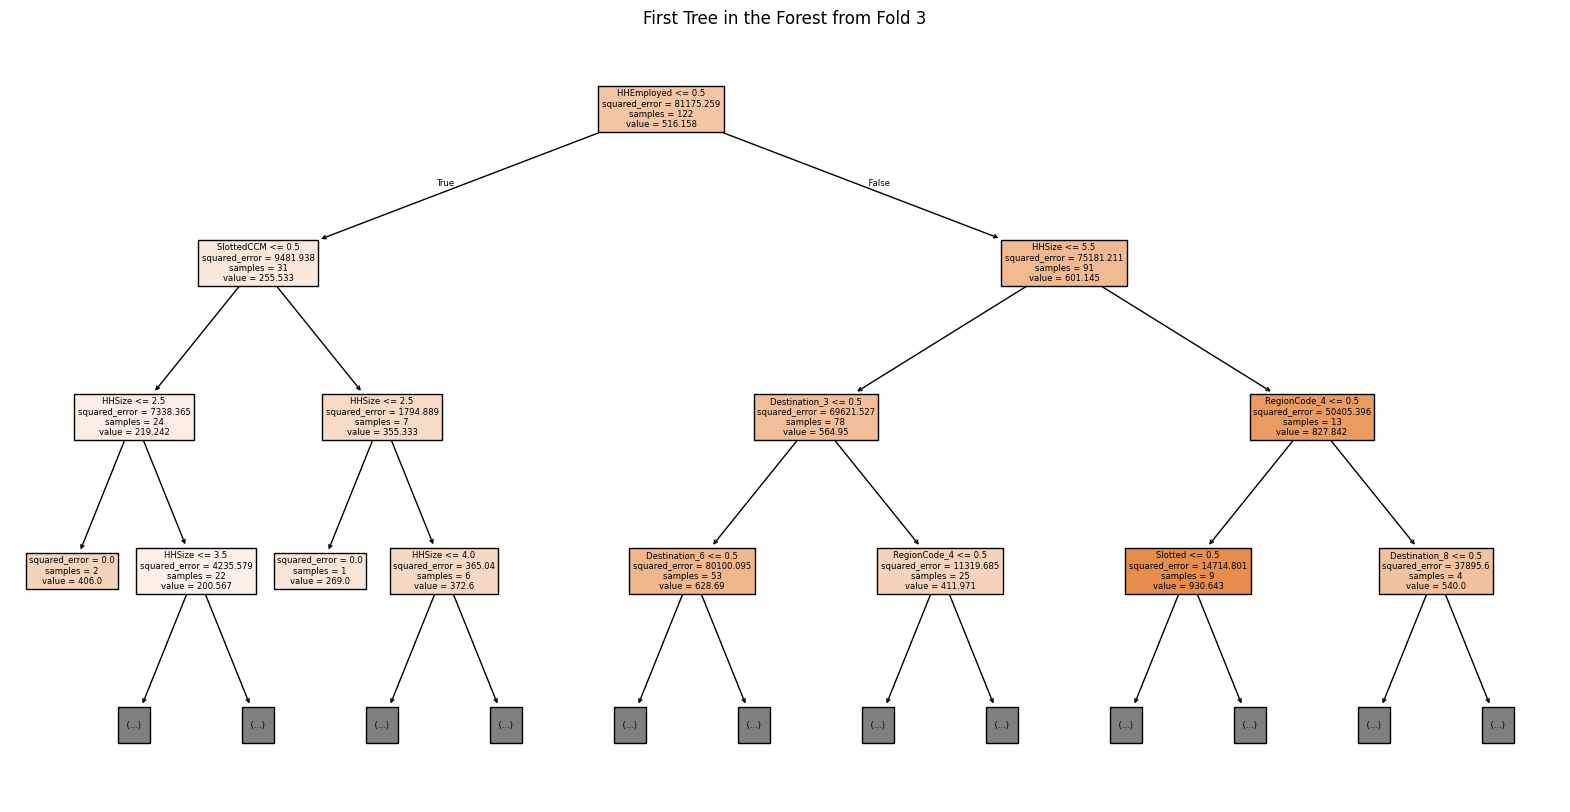

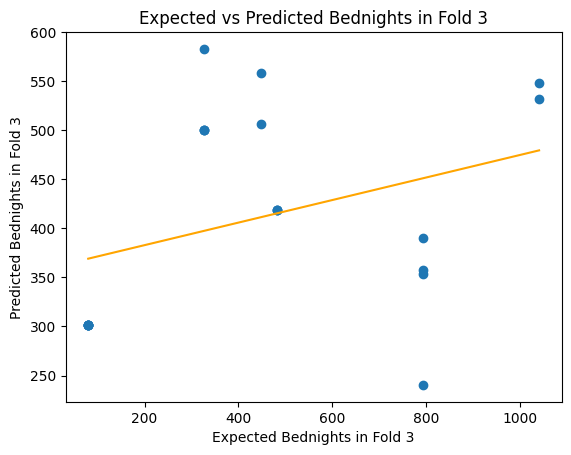

Fold 3 - MSE: 87478.6272, RMSE: 295.7679, R^2: 0.1073
HHSize: 0.2013
HHEmployed: 0.3128
HHTANF: 0.0389
Slotted: 0.0156
SlottedCCM: 0.0161
SlottedPME: 0.0152
SingleMom: 0.0088
SingleDad: 0.0093
SingleParent: 0.0049
Disability: 0.0026
RegionCode_1: 0.0266
RegionCode_2: 0.0156
RegionCode_3: 0.0087
RegionCode_4: 0.0367
RegionCode_5: 0.0000
Destination_2: 0.0004
Destination_3: 0.0472
Destination_4: 0.0397
Destination_5: 0.0305
Destination_6: 0.0405
Destination_7: 0.0069
Destination_8: 0.0182
Destination_9: 0.0059
Destination_10: 0.0253
Destination_11: 0.0241
HHSize_bin_small: 0.0247
HHSize_bin_big: 0.0235


<Figure size 640x480 with 0 Axes>

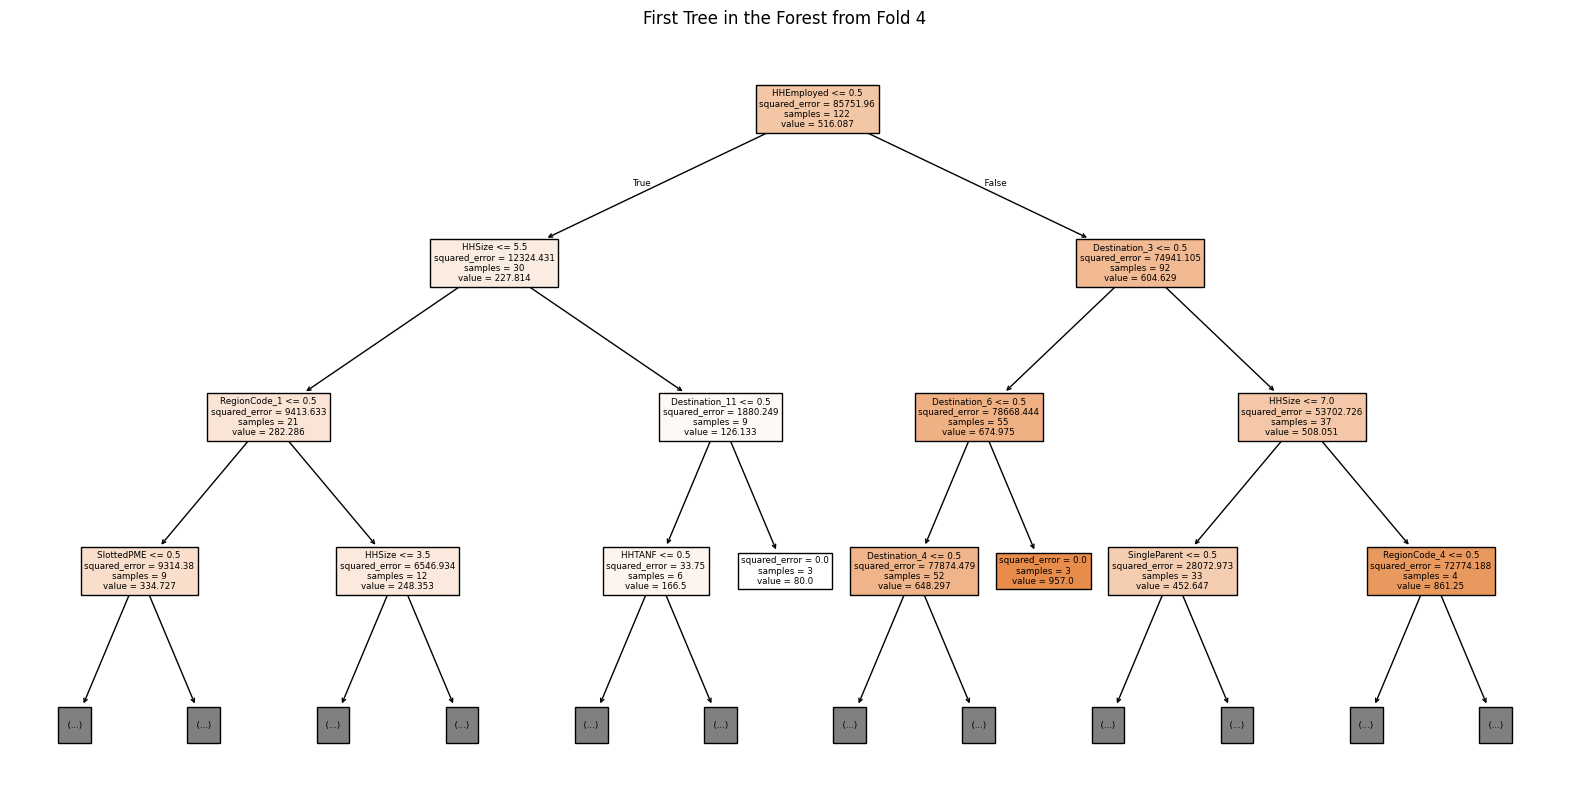

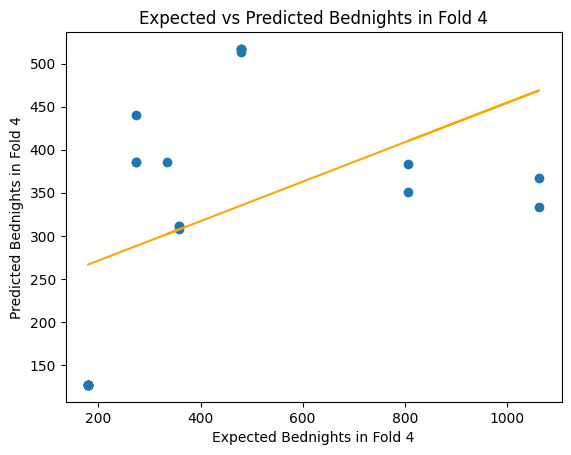

Fold 4 - MSE: 70889.1361, RMSE: 266.2501, R^2: 0.0515
HHSize: 0.2231
HHEmployed: 0.2308
HHTANF: 0.0452
Slotted: 0.0178
SlottedCCM: 0.0211
SlottedPME: 0.0189
SingleMom: 0.0105
SingleDad: 0.0105
SingleParent: 0.0031
Disability: 0.0035
RegionCode_1: 0.0211
RegionCode_2: 0.0179
RegionCode_3: 0.0095
RegionCode_4: 0.0285
RegionCode_5: 0.0000
Destination_2: 0.0007
Destination_3: 0.1083
Destination_4: 0.0433
Destination_5: 0.0327
Destination_6: 0.0000
Destination_7: 0.0097
Destination_8: 0.0155
Destination_9: 0.0183
Destination_10: 0.0241
Destination_11: 0.0228
HHSize_bin_small: 0.0384
HHSize_bin_big: 0.0246


<Figure size 640x480 with 0 Axes>

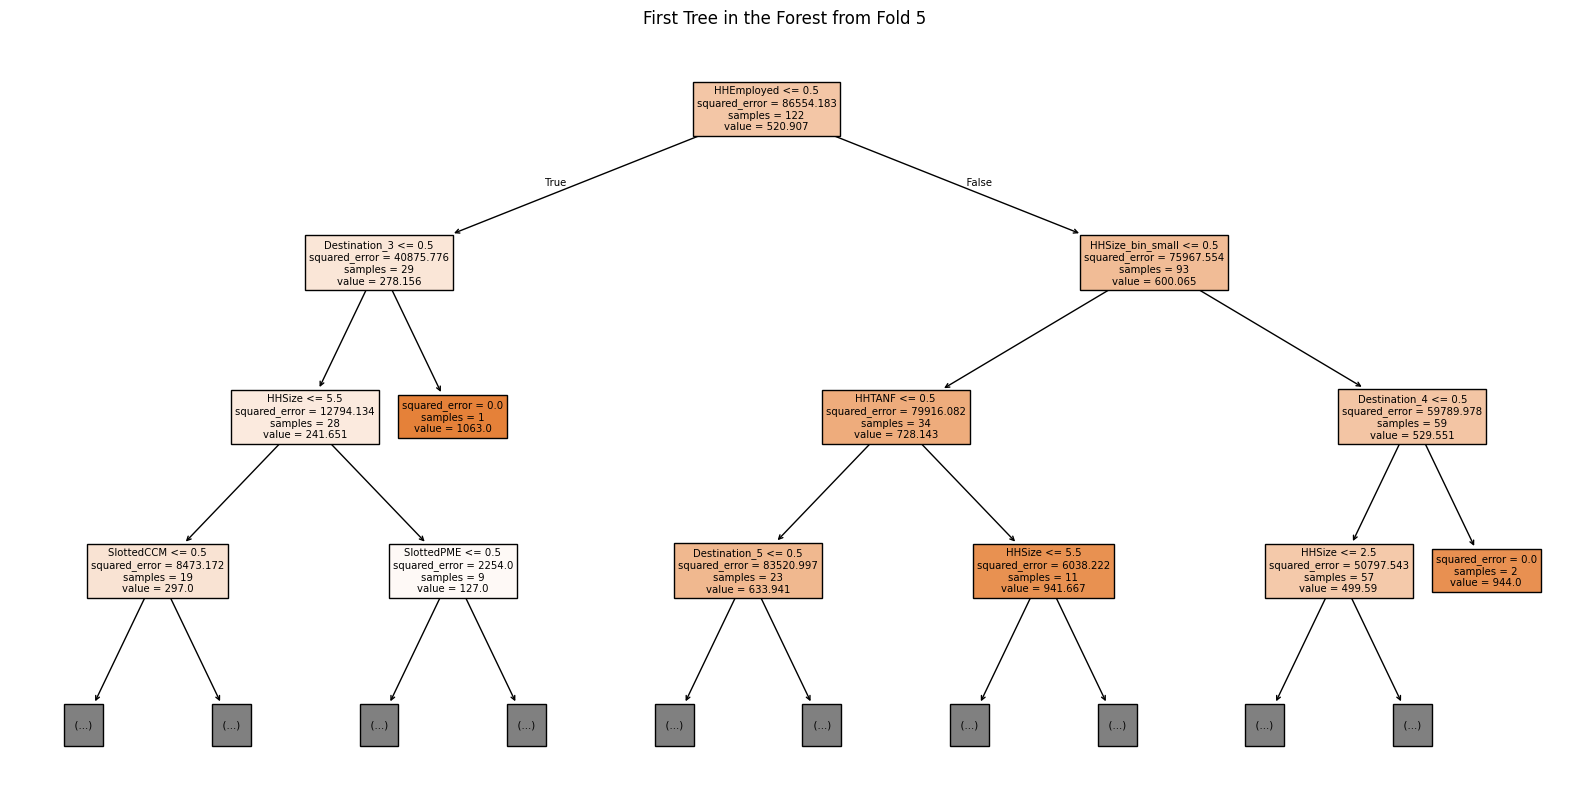

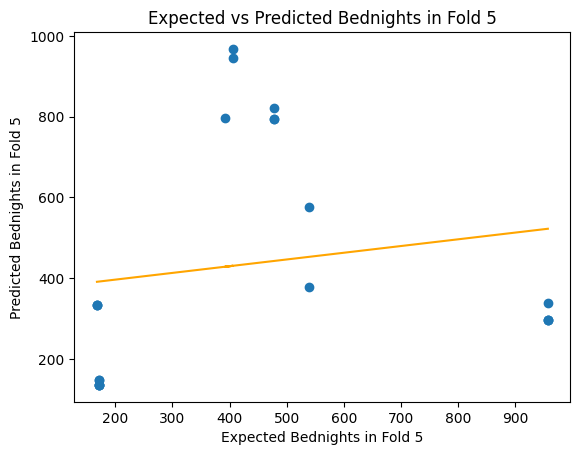

Fold 5 - MSE: 137945.2470, RMSE: 371.4098, R^2: -0.6532
HHSize: 0.2396
HHEmployed: 0.2619
HHTANF: 0.0265
Slotted: 0.0195
SlottedCCM: 0.0227
SlottedPME: 0.0123
SingleMom: 0.0059
SingleDad: 0.0029
SingleParent: 0.0024
Disability: 0.0008
RegionCode_1: 0.0240
RegionCode_2: 0.0296
RegionCode_3: 0.0080
RegionCode_4: 0.0187
RegionCode_5: 0.0003
Destination_2: 0.0005
Destination_3: 0.0964
Destination_4: 0.0436
Destination_5: 0.0315
Destination_6: 0.0475
Destination_7: 0.0031
Destination_8: 0.0171
Destination_9: 0.0241
Destination_10: 0.0000
Destination_11: 0.0237
HHSize_bin_small: 0.0187
HHSize_bin_big: 0.0188


<Figure size 640x480 with 0 Axes>

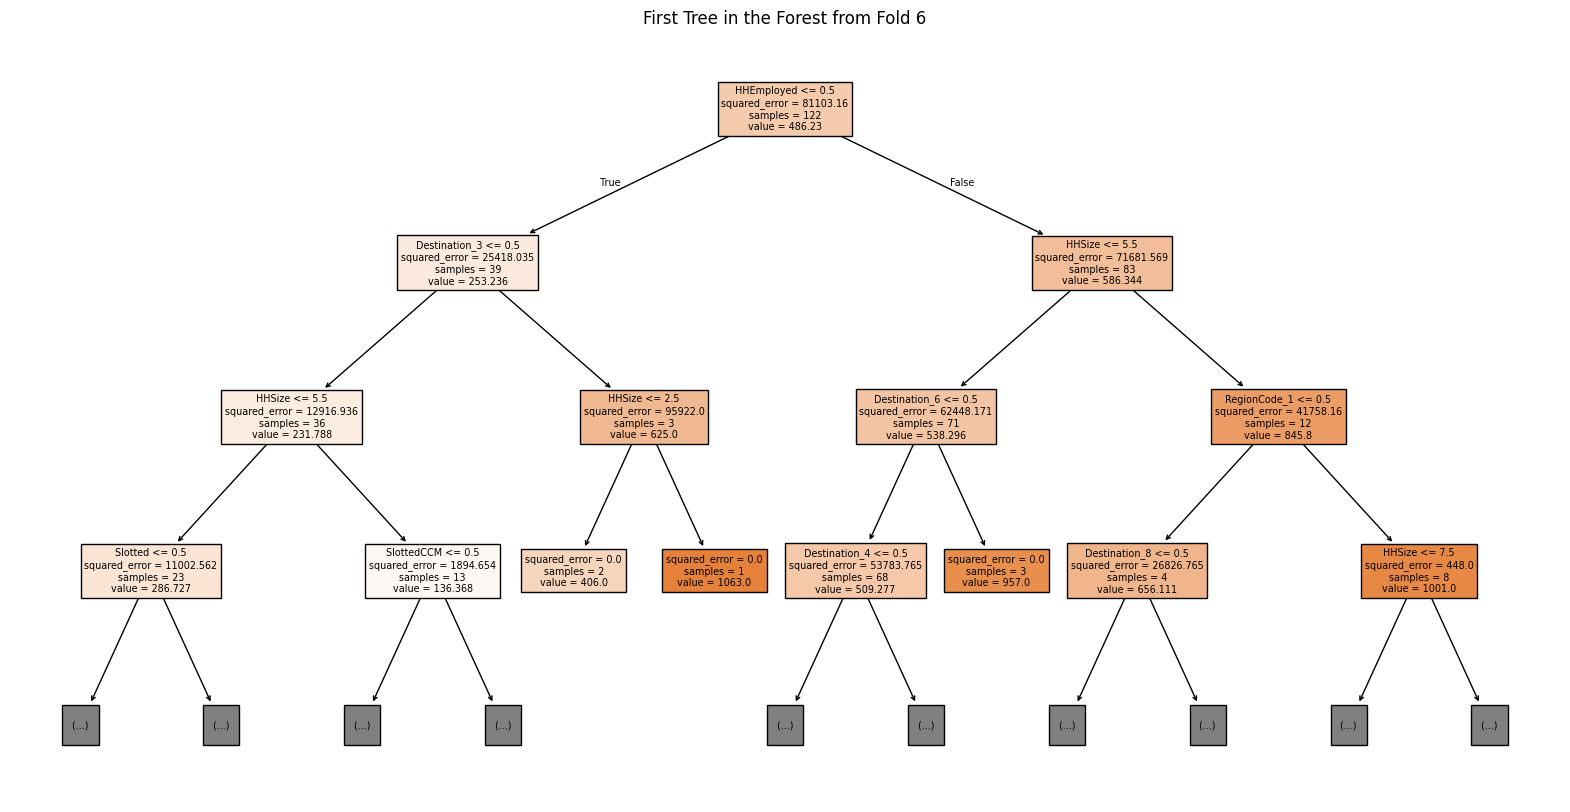

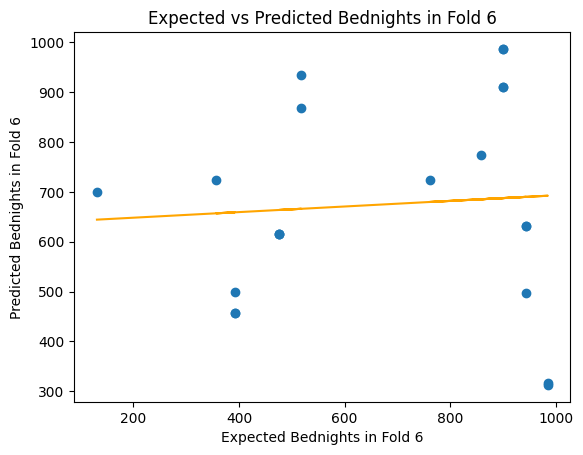

Fold 6 - MSE: 102498.9966, RMSE: 320.1546, R^2: -0.4759
HHSize: 0.1848
HHEmployed: 0.3091
HHTANF: 0.0198
Slotted: 0.0156
SlottedCCM: 0.0177
SlottedPME: 0.0042
SingleMom: 0.0089
SingleDad: 0.0058
SingleParent: 0.0062
Disability: 0.0000
RegionCode_1: 0.0122
RegionCode_2: 0.0137
RegionCode_3: 0.0107
RegionCode_4: 0.0320
RegionCode_5: 0.0000
Destination_2: 0.0005
Destination_3: 0.1139
Destination_4: 0.0406
Destination_5: 0.0099
Destination_6: 0.0440
Destination_7: 0.0000
Destination_8: 0.0129
Destination_9: 0.0172
Destination_10: 0.0287
Destination_11: 0.0189
HHSize_bin_small: 0.0324
HHSize_bin_big: 0.0401


<Figure size 640x480 with 0 Axes>

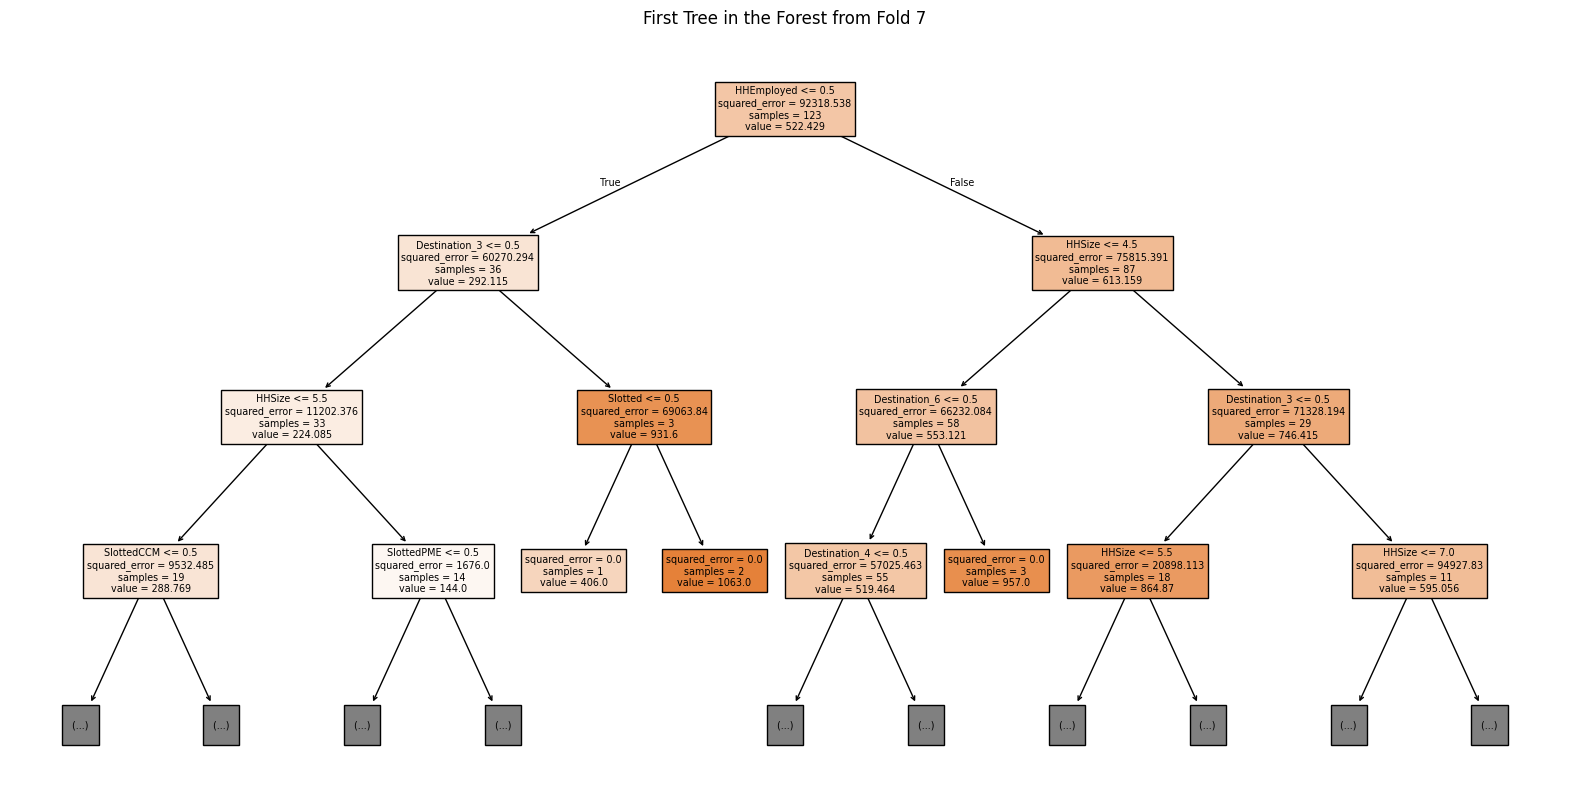

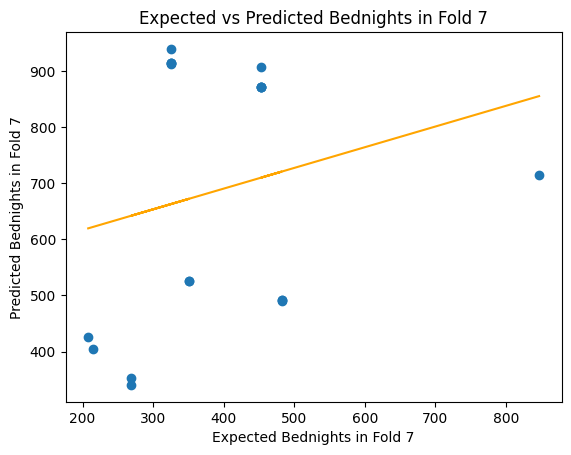

Fold 7 - MSE: 141958.6297, RMSE: 376.7740, R^2: -6.6629
HHSize: 0.1852
HHEmployed: 0.3043
HHTANF: 0.0403
Slotted: 0.0167
SlottedCCM: 0.0204
SlottedPME: 0.0150
SingleMom: 0.0096
SingleDad: 0.0056
SingleParent: 0.0063
Disability: 0.0008
RegionCode_1: 0.0173
RegionCode_2: 0.0235
RegionCode_3: 0.0191
RegionCode_4: 0.0311
RegionCode_5: 0.0003
Destination_2: 0.0005
Destination_3: 0.0979
Destination_4: 0.0289
Destination_5: 0.0256
Destination_6: 0.0425
Destination_7: 0.0051
Destination_8: 0.0044
Destination_9: 0.0154
Destination_10: 0.0204
Destination_11: 0.0195
HHSize_bin_small: 0.0234
HHSize_bin_big: 0.0210


<Figure size 640x480 with 0 Axes>

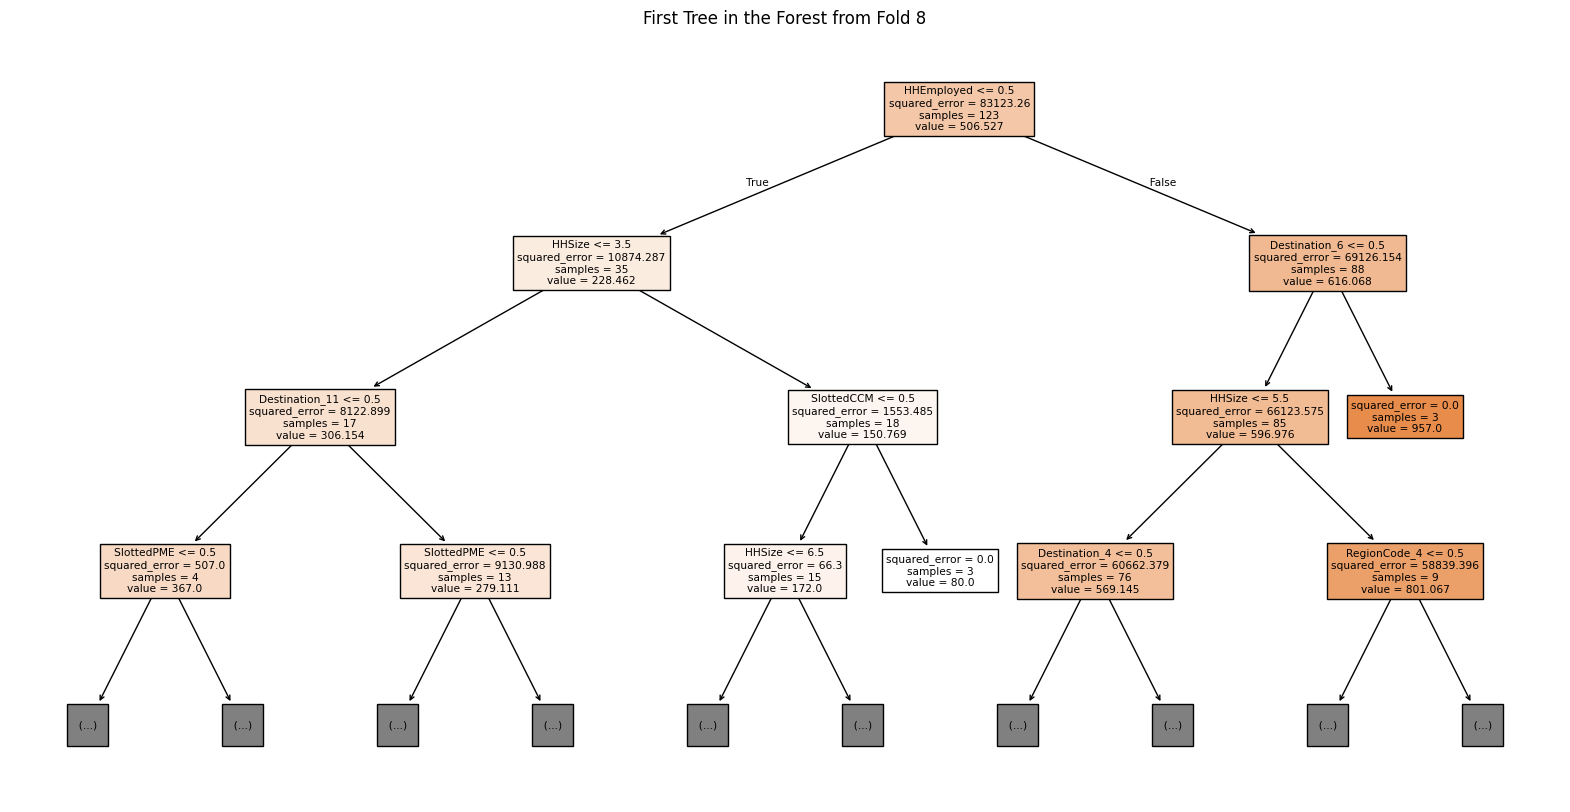

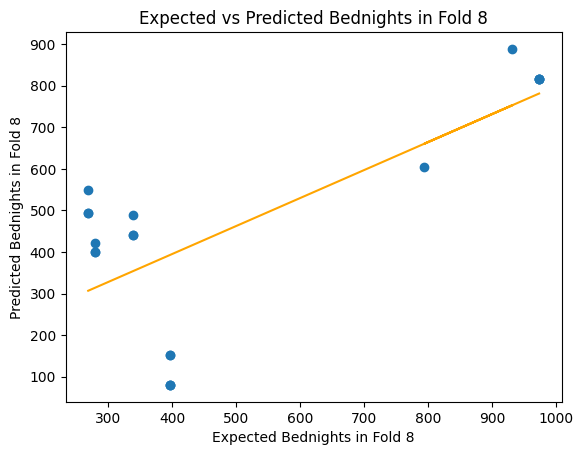

Fold 8 - MSE: 41379.2829, RMSE: 203.4190, R^2: 0.4830
HHSize: 0.2421
HHEmployed: 0.2512
HHTANF: 0.0421
Slotted: 0.0257
SlottedCCM: 0.0149
SlottedPME: 0.0153
SingleMom: 0.0147
SingleDad: 0.0042
SingleParent: 0.0052
Disability: 0.0000
RegionCode_1: 0.0183
RegionCode_2: 0.0133
RegionCode_3: 0.0140
RegionCode_4: 0.0325
RegionCode_5: 0.0000
Destination_2: 0.0005
Destination_3: 0.0883
Destination_4: 0.0027
Destination_5: 0.0286
Destination_6: 0.0491
Destination_7: 0.0071
Destination_8: 0.0165
Destination_9: 0.0177
Destination_10: 0.0280
Destination_11: 0.0228
HHSize_bin_small: 0.0218
HHSize_bin_big: 0.0237


<Figure size 640x480 with 0 Axes>

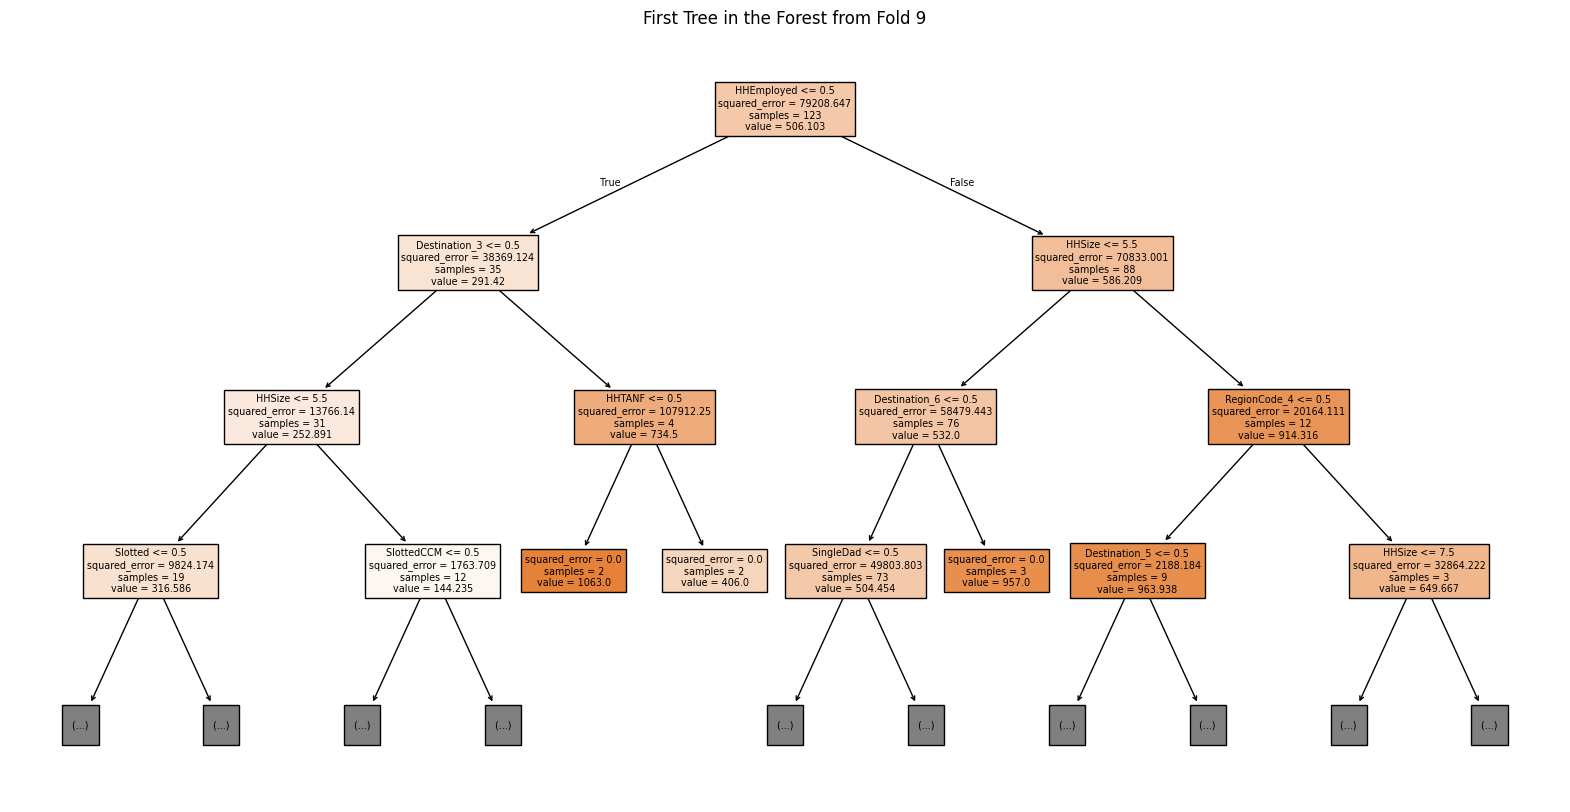

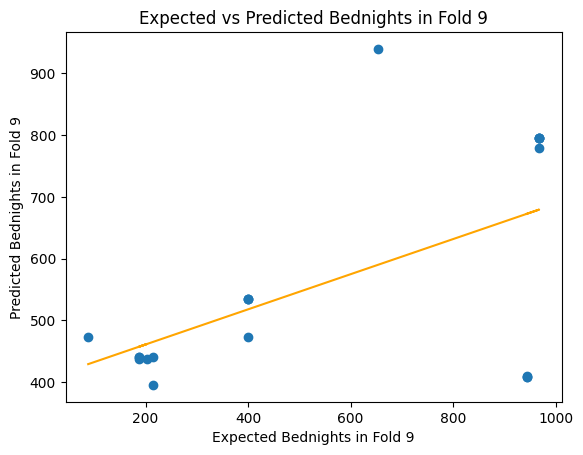

Fold 9 - MSE: 81645.2607, RMSE: 285.7363, R^2: 0.3180
HHSize: 0.2389
HHEmployed: 0.2434
HHTANF: 0.0451
Slotted: 0.0312
SlottedCCM: 0.0150
SlottedPME: 0.0221
SingleMom: 0.0123
SingleDad: 0.0070
SingleParent: 0.0055
Disability: 0.0005
RegionCode_1: 0.0284
RegionCode_2: 0.0230
RegionCode_3: 0.0099
RegionCode_4: 0.0365
RegionCode_5: 0.0000
Destination_2: 0.0007
Destination_3: 0.0862
Destination_4: 0.0444
Destination_5: 0.0050
Destination_6: 0.0470
Destination_7: 0.0010
Destination_8: 0.0170
Destination_9: 0.0139
Destination_10: 0.0268
Destination_11: 0.0151
HHSize_bin_small: 0.0121
HHSize_bin_big: 0.0120


<Figure size 640x480 with 0 Axes>

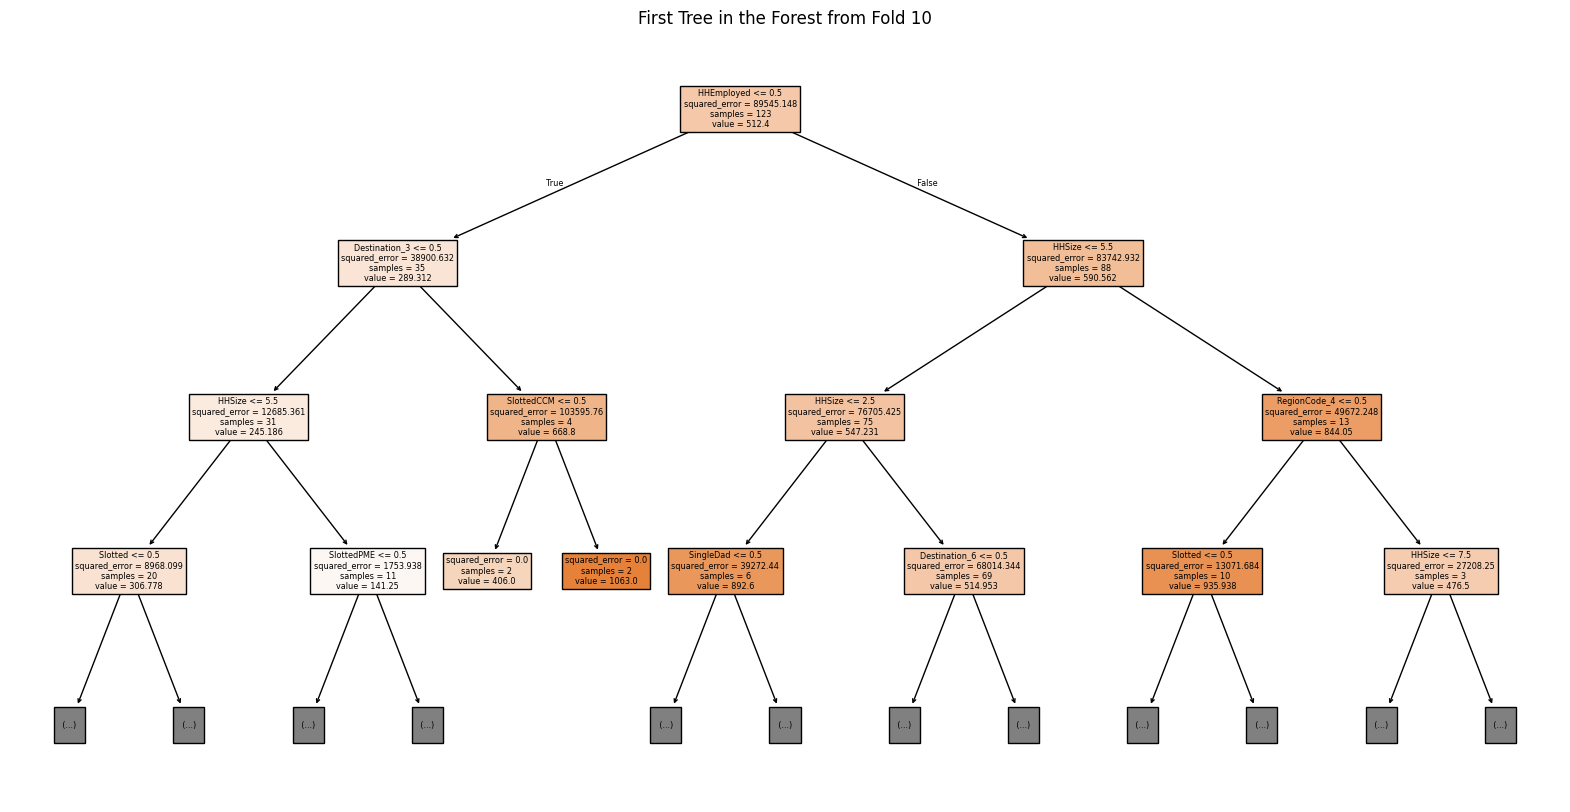

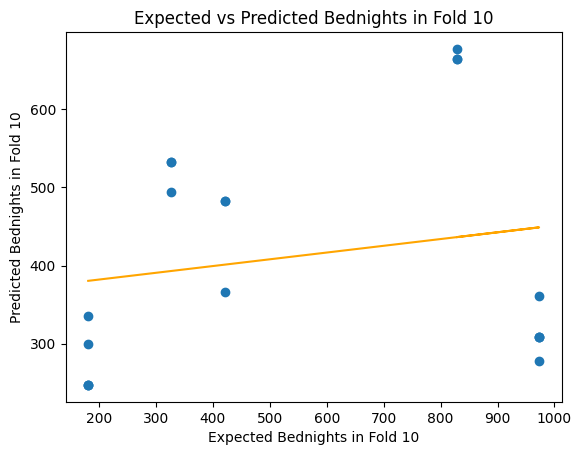

Fold 10 - MSE: 128004.7114, RMSE: 357.7775, R^2: -0.2109


<Figure size 640x480 with 0 Axes>

In [20]:
##Forest Regression: predict bednights. GKF - set up folds for cross validation and to handle autocorrelation
gkf = GroupKFold(n_splits=10)

##Loop through folds to split the data for testing and training, fitting model, show fitness, and evaluate
for fold, (train_idx, test_idx) in enumerate(gkf.split(x, y, groups)):
    x_train, x_test = x.iloc[train_idx], x.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    ##train (pipeline handles transforming data and training the model at the same time and reproducibly, it's coming together in my head)
    ##get estimators and column names to show tree
    ##get importances of each feature to improve model
    model = RandomForestRegressor(random_state=42)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    first_tree = model.estimators_[0]
    feature_names = x.columns
    importances = model.feature_importances_
    for name, importance in zip(
        feature_names, importances):
        print(f'{name}: {importance:.4f}')

    ##show tree
    plt.figure(figsize=(20, 10))
    plot_tree(first_tree,
             feature_names=feature_names,
             filled=True,
             rounded=False,
             max_depth=3)
    plt.title(f'First Tree in the Forest from Fold {fold+1}')
    plt.show()
    plt.clf()

    ##show fitness
    plt.scatter(y_test, y_pred)
    plt.xlabel(f'Expected Bednights in Fold {fold+1}')
    plt.ylabel(f'Predicted Bednights in Fold {fold+1}')
    plt.title(f'Expected vs Predicted Bednights in Fold {fold+1}')
    a, b = np.polyfit(y_test, y_pred, 1)
    plt.plot(y_test, a * y_test + b, color='orange')
    plt.show()
    plt.clf()

    ##Evaluate
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    print(f'Fold {fold+1} - MSE: {mse:.4f}, RMSE: {rmse:.4f}, R^2: {r2:.4f}')

Goal 2: Improve. Random Forest Regression has worse R^2 values than Linear Regression. Retrain using aggregate importances and subset of features to maximize cross-validated r2.

In [7]:
##Improve Forest Regression: predict bednights. initialize variables / lists
importances_all_folds = []

In [8]:
##Improve Forest Regression: predict bednights. Train multiple models to select features and collect importances
for fold, (train_idx, test_idx) in enumerate(gkf.split(x,y,groups)):
    x_train, y_train = x.iloc[train_idx], y.iloc[train_idx]

    model = RandomForestRegressor(random_state = 42)
    model.fit(x_train, y_train)

    importances_all_folds.append(model.feature_importances_)
    
importances_all_folds = np.array(importances_all_folds)

In [9]:
##Improve Forest Regression: predict bednights. aggregate and df importances to choose most effective features for the model most easily, dynamically
mean_importances = np.mean(importances_all_folds, axis=0)
feature_importances = pd.DataFrame({
    'feature': x.columns,
    'importance': mean_importances}).sort_values(by='importance',ascending=False)
print(feature_importances)

             feature  importance
1         HHEmployed    0.262789
0             HHSize    0.213897
16     Destination_3    0.106928
19     Destination_6    0.040016
2             HHTANF    0.038092
17     Destination_4    0.031833
26    HHSize_bin_big    0.029575
13      RegionCode_4    0.028318
25  HHSize_bin_small    0.025565
10      RegionCode_1    0.023459
18     Destination_5    0.021951
23    Destination_10    0.021704
24    Destination_11    0.020968
4         SlottedCCM    0.019460
3            Slotted    0.018641
21     Destination_8    0.018578
11      RegionCode_2    0.017425
5         SlottedPME    0.013580
22     Destination_9    0.012877
12      RegionCode_3    0.012395
6          SingleMom    0.008199
7          SingleDad    0.005092
8       SingleParent    0.004143
20     Destination_7    0.003425
15     Destination_2    0.000854
9         Disability    0.000234
14      RegionCode_5    0.000001


In [10]:
##Improve Forest Regression: predict bednights. define thresholds, select features with importance above threshold,
##train and cross validate a model with gkf using selected features, identify best r2 and best features,
##Define thresholds and select features
thresholds = np.linspace(0, mean_importances.max(), num=20)

##initialize best_score and best_scores
best_score = -np.inf
best_features = None

##select features and train models with each subset to determine best r2 and best model
for thresh in thresholds:
    selected_features = feature_importances[feature_importances['importance'] >= thresh]['feature'].tolist()

    if not selected_features:
        continue

    x_selected = x[selected_features]

    ##train models and cross validate with gkf
    model = RandomForestRegressor(random_state = 42)
    scores = cross_val_score(model, x_selected, y, cv=gkf, groups=groups, scoring='r2')

    mean_score = np.mean(scores)
    print(f'Threshold {thresh:.4f}: Selected {len(selected_features)} features, Mean R^2 = {mean_score:.4f}')

    ##idenitfy best score and features
    if mean_score > best_score:
        best_score = mean_score
        best_features = selected_features

##Display best score and features
print(f'Selected {len(best_features)} features with mean R^2 = {best_score:.4f}')
print('Selected features', best_features)

Threshold 0.0000: Selected 27 features, Mean R^2 = -0.3299
Threshold 0.0138: Selected 17 features, Mean R^2 = -0.3277
Threshold 0.0277: Selected 8 features, Mean R^2 = -0.3161
Threshold 0.0415: Selected 3 features, Mean R^2 = -0.3092
Threshold 0.0553: Selected 3 features, Mean R^2 = -0.3092
Threshold 0.0692: Selected 3 features, Mean R^2 = -0.3092
Threshold 0.0830: Selected 3 features, Mean R^2 = -0.3092
Threshold 0.0968: Selected 3 features, Mean R^2 = -0.3092
Threshold 0.1106: Selected 2 features, Mean R^2 = 0.0875
Threshold 0.1245: Selected 2 features, Mean R^2 = 0.0875
Threshold 0.1383: Selected 2 features, Mean R^2 = 0.0875
Threshold 0.1521: Selected 2 features, Mean R^2 = 0.0875
Threshold 0.1660: Selected 2 features, Mean R^2 = 0.0875
Threshold 0.1798: Selected 2 features, Mean R^2 = 0.0875
Threshold 0.1936: Selected 2 features, Mean R^2 = 0.0875
Threshold 0.2075: Selected 2 features, Mean R^2 = 0.0875
Threshold 0.2213: Selected 1 features, Mean R^2 = 0.0813
Threshold 0.2351: Sel

Goal: train model using the best feature identified above

Fold 1 best params: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 200}


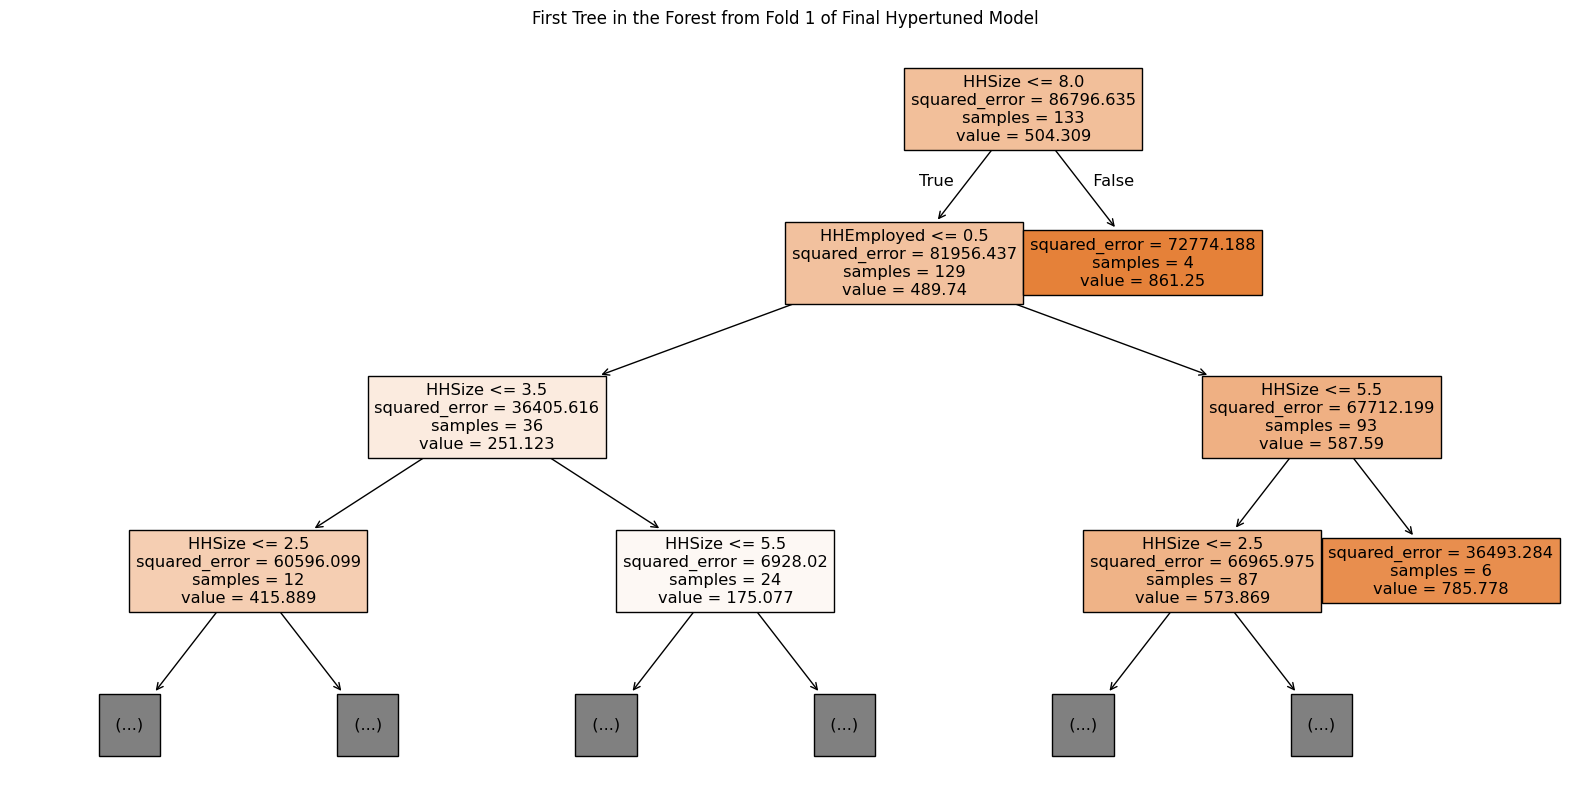

C:\Users\morel\AppData\Local\Temp\ipykernel_21620\3034712108.py:46: OptimizeWarning: Covariance of the parameters could not be estimated
  params, covariance = curve_fit(logistic_func, y_test, y_pred)


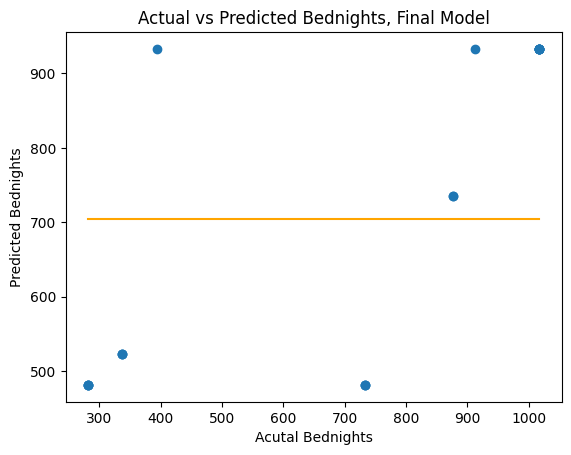

Fold 1 - MSE: 39615.4559, RMSE: 199.0363, R^2: 0.5842
Fold 2 best params: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 200}


<Figure size 640x480 with 0 Axes>

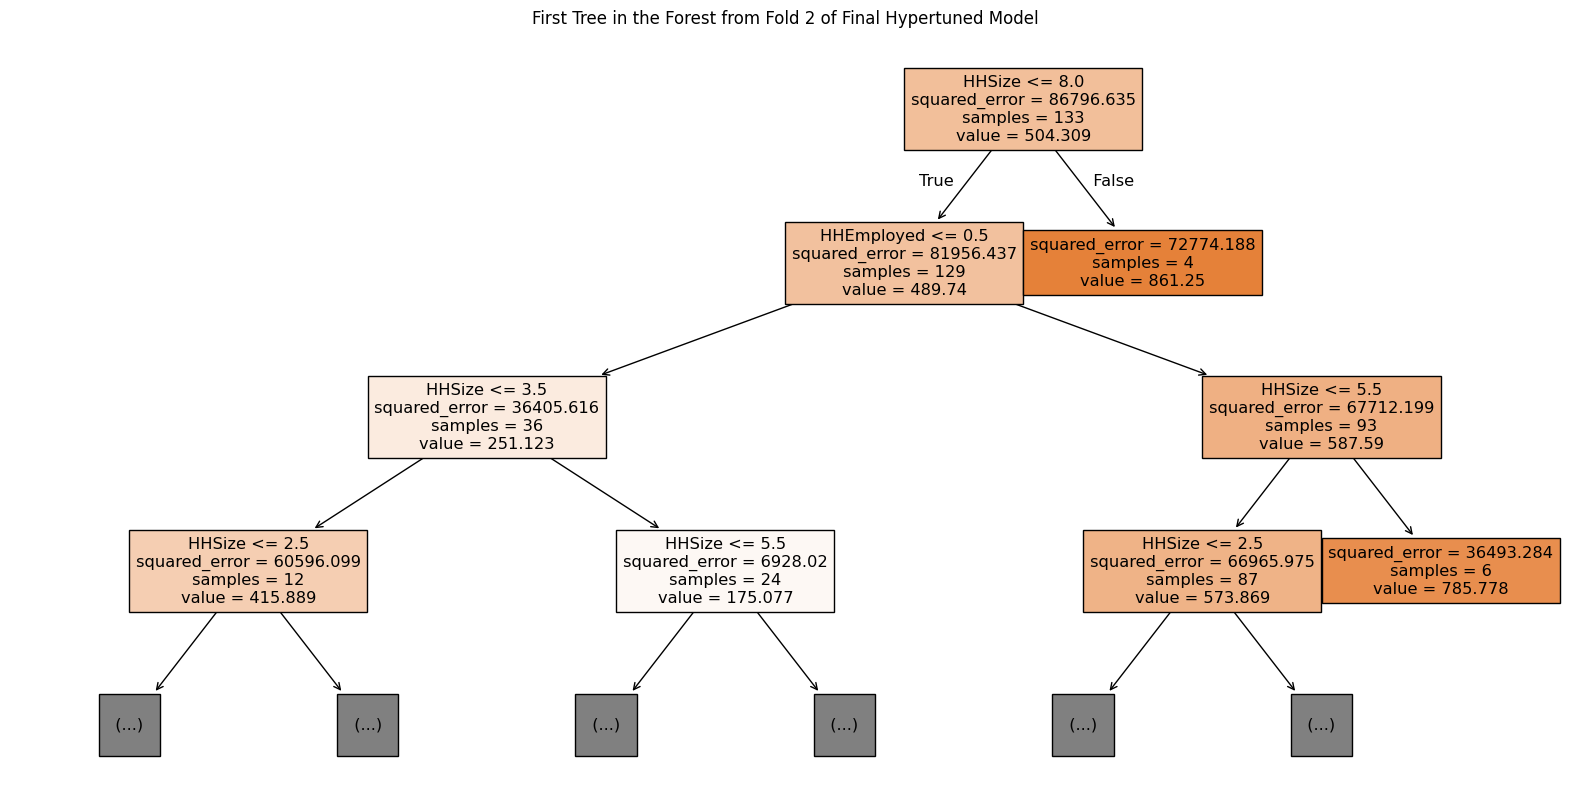

C:\Users\morel\AppData\Local\Temp\ipykernel_21620\3034712108.py:46: OptimizeWarning: Covariance of the parameters could not be estimated
  params, covariance = curve_fit(logistic_func, y_test, y_pred)


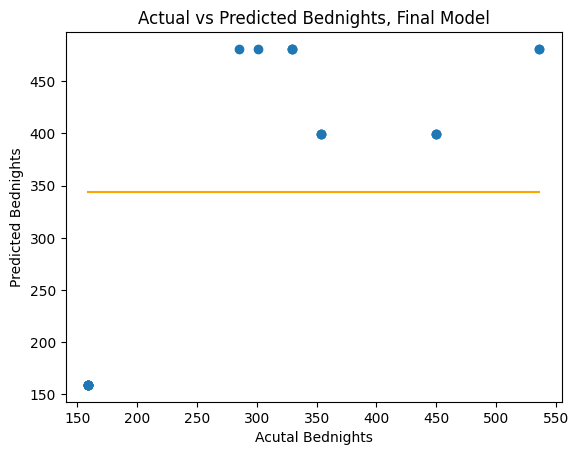

Fold 2 - MSE: 8007.1264, RMSE: 89.4825, R^2: 0.5119
Fold 3 best params: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 200}


<Figure size 640x480 with 0 Axes>

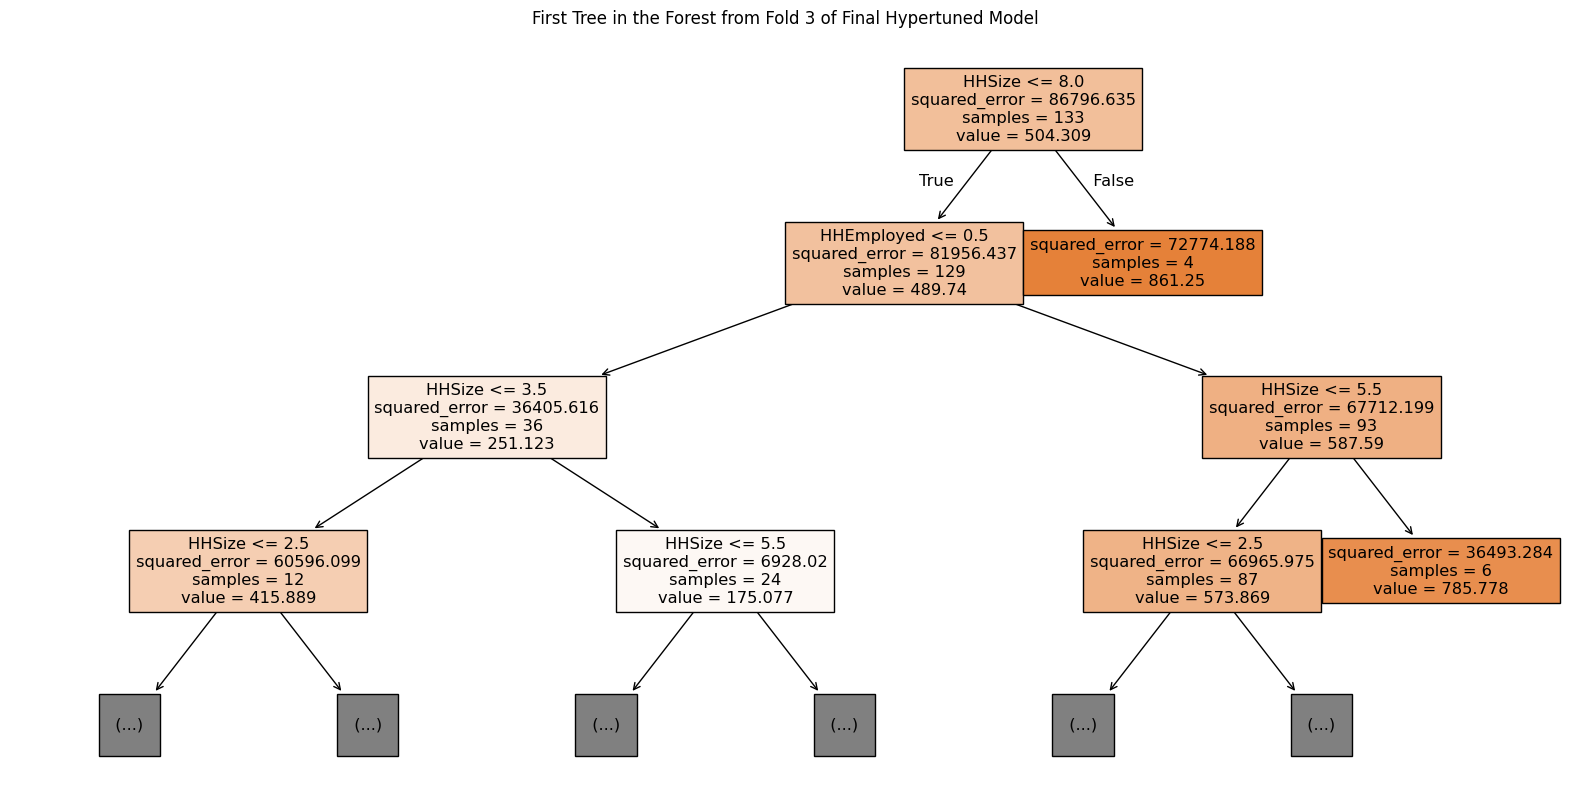

C:\Users\morel\AppData\Local\Temp\ipykernel_21620\3034712108.py:46: OptimizeWarning: Covariance of the parameters could not be estimated
  params, covariance = curve_fit(logistic_func, y_test, y_pred)


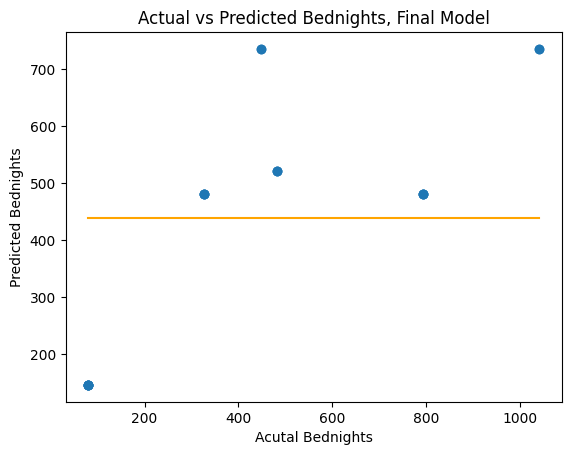

Fold 3 - MSE: 41453.5678, RMSE: 203.6015, R^2: 0.5770
Fold 4 best params: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 200}


<Figure size 640x480 with 0 Axes>

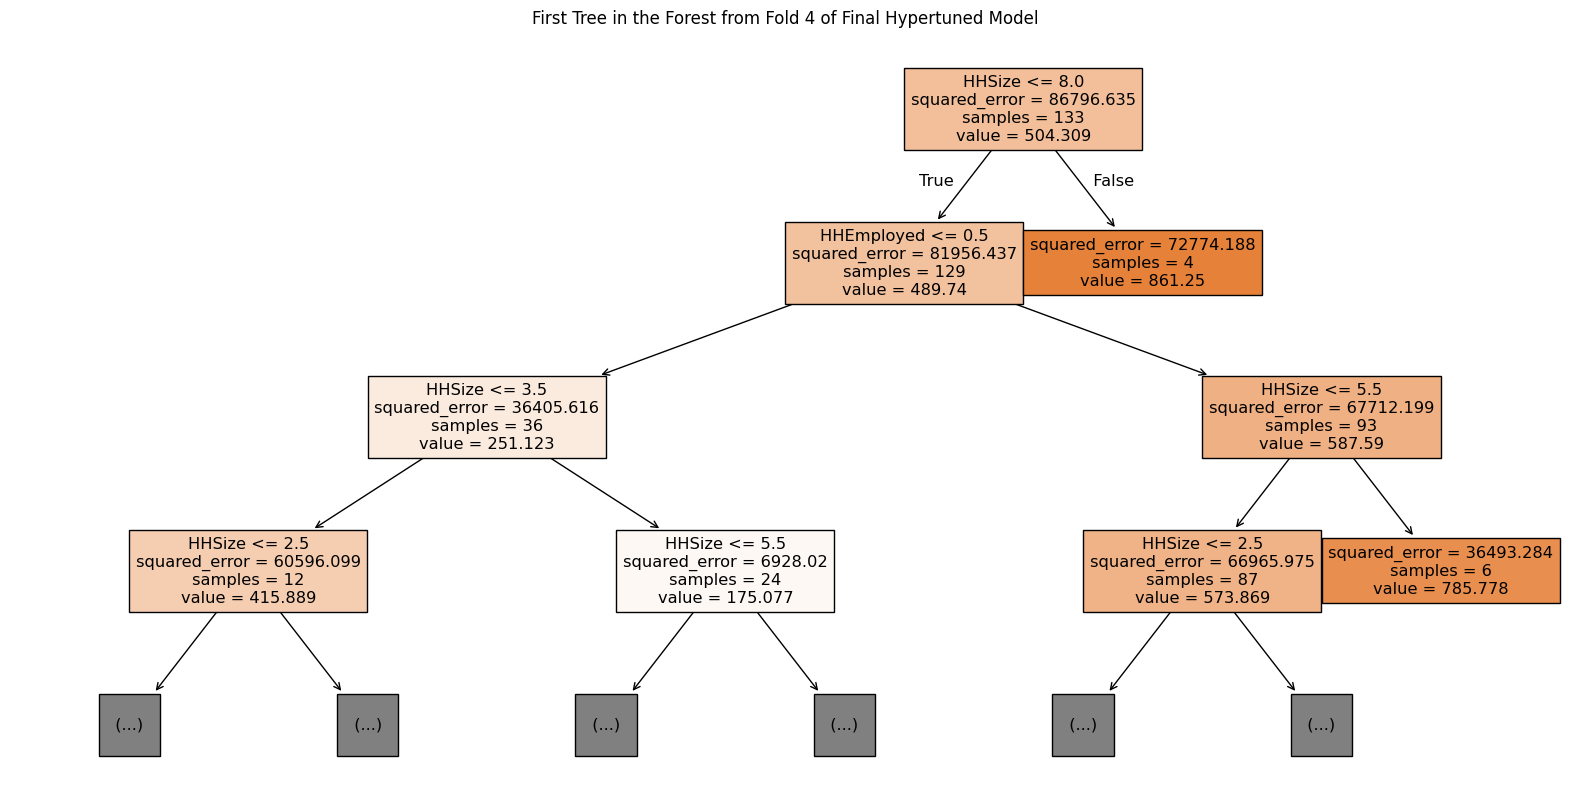

C:\Users\morel\AppData\Local\Temp\ipykernel_21620\3034712108.py:46: OptimizeWarning: Covariance of the parameters could not be estimated
  params, covariance = curve_fit(logistic_func, y_test, y_pred)


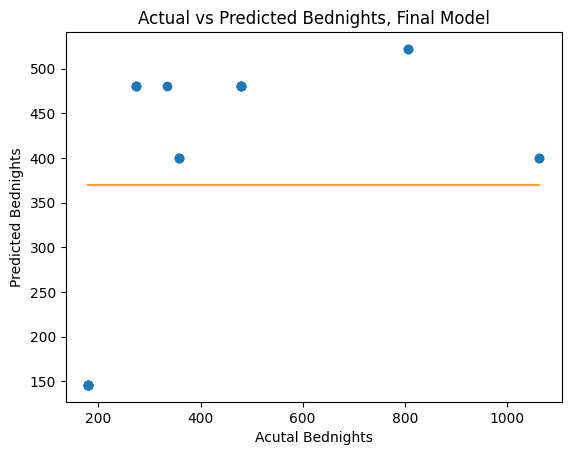

Fold 4 - MSE: 57413.7006, RMSE: 239.6116, R^2: 0.2318
Fold 5 best params: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 200}


<Figure size 640x480 with 0 Axes>

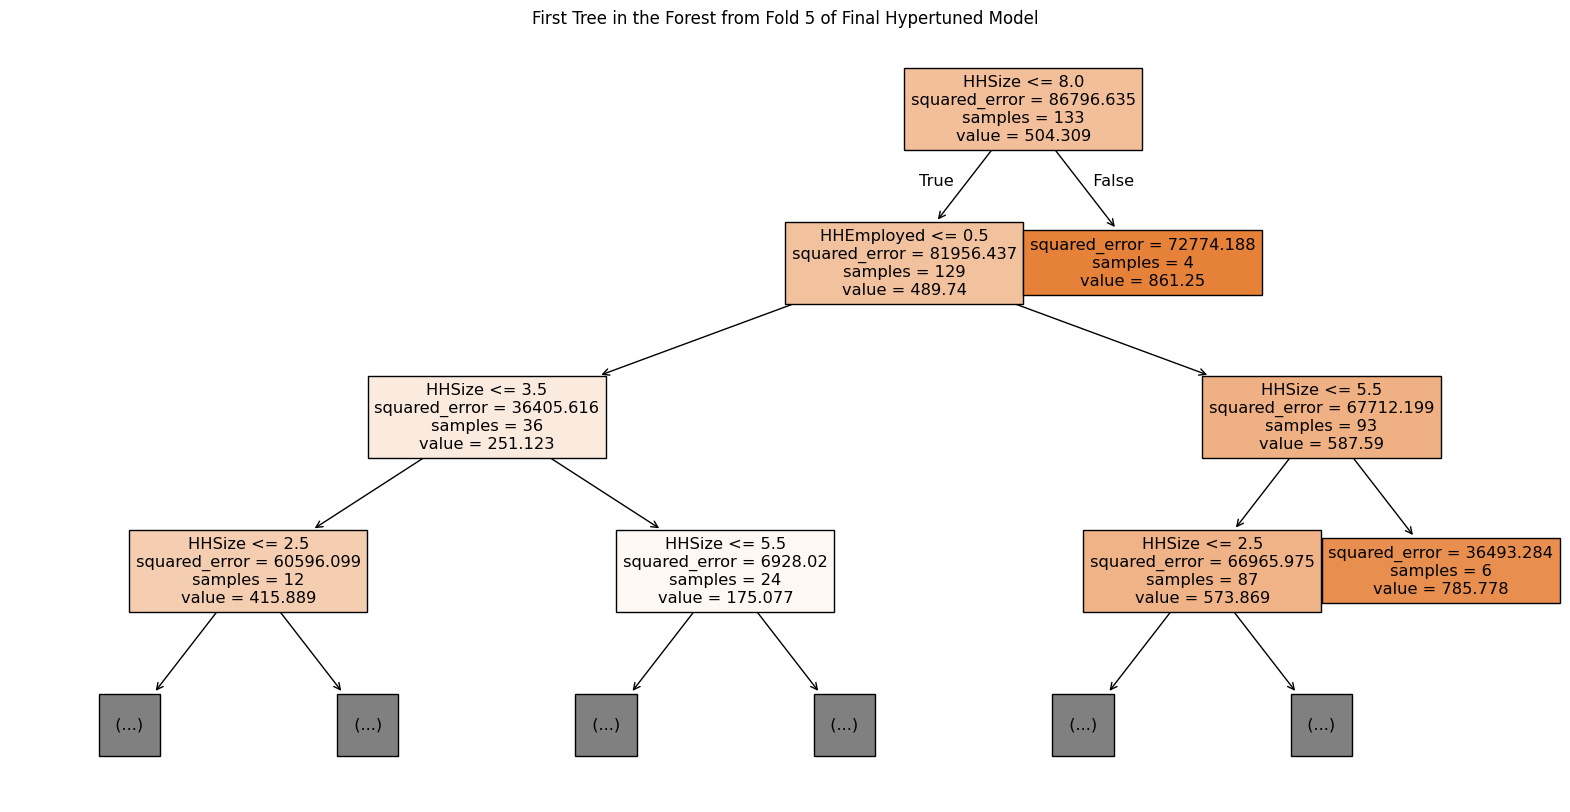

C:\Users\morel\AppData\Local\Temp\ipykernel_21620\3034712108.py:46: OptimizeWarning: Covariance of the parameters could not be estimated
  params, covariance = curve_fit(logistic_func, y_test, y_pred)


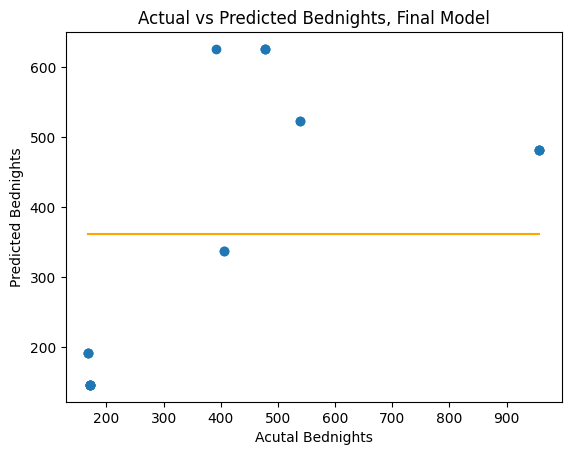

Fold 5 - MSE: 49645.2324, RMSE: 222.8121, R^2: 0.4050
Fold 6 best params: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 200}


<Figure size 640x480 with 0 Axes>

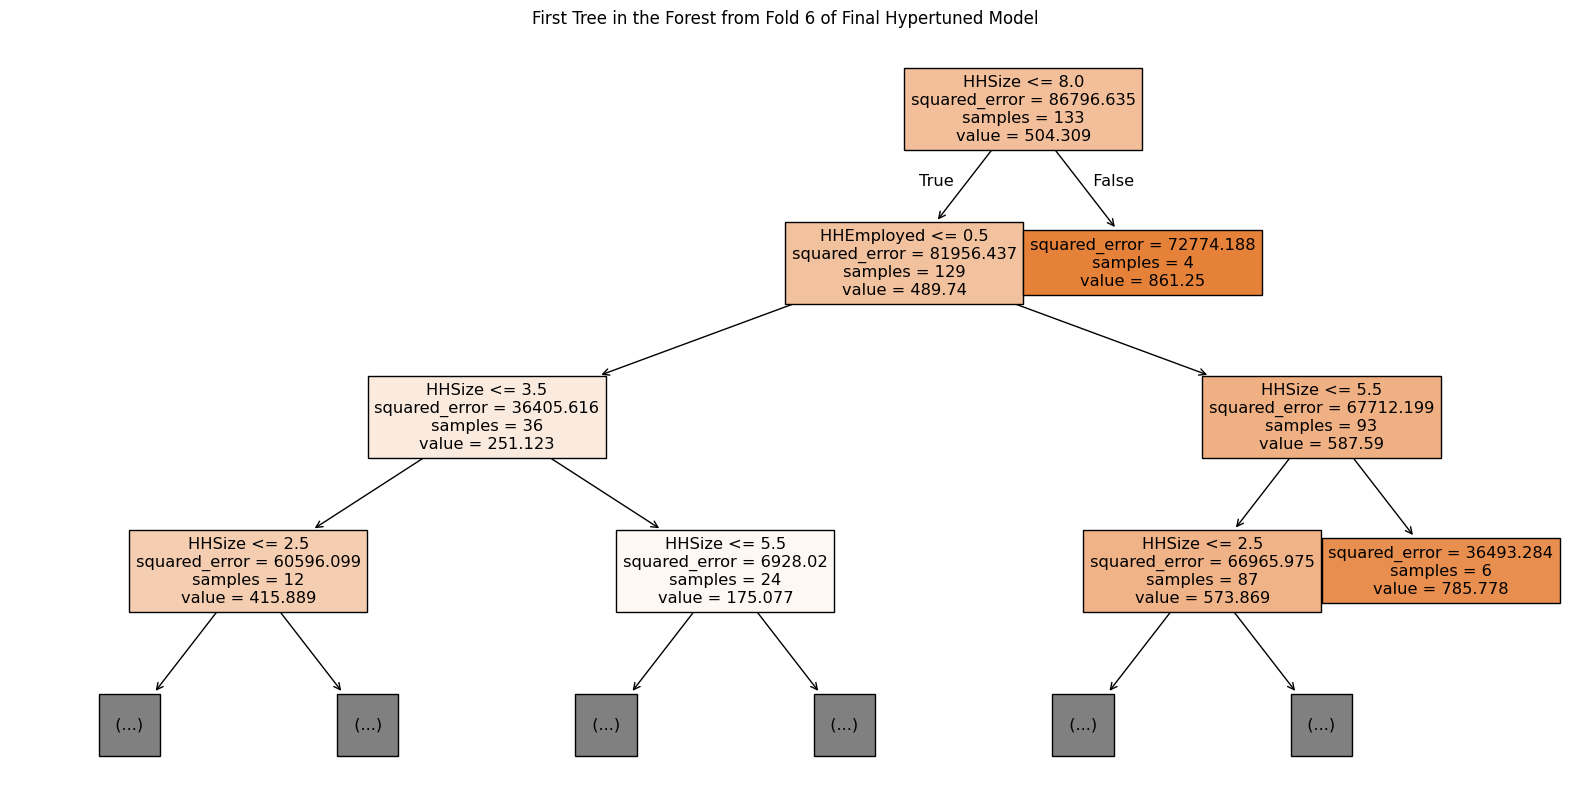

C:\Users\morel\AppData\Local\Temp\ipykernel_21620\3034712108.py:46: OptimizeWarning: Covariance of the parameters could not be estimated
  params, covariance = curve_fit(logistic_func, y_test, y_pred)


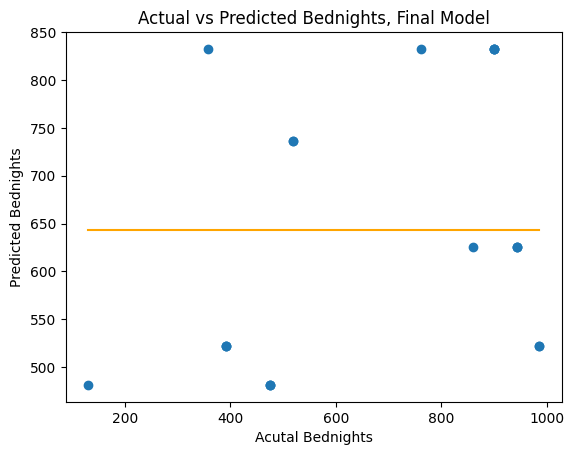

Fold 6 - MSE: 62131.5171, RMSE: 249.2619, R^2: 0.1054
Fold 7 best params: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 200}


<Figure size 640x480 with 0 Axes>

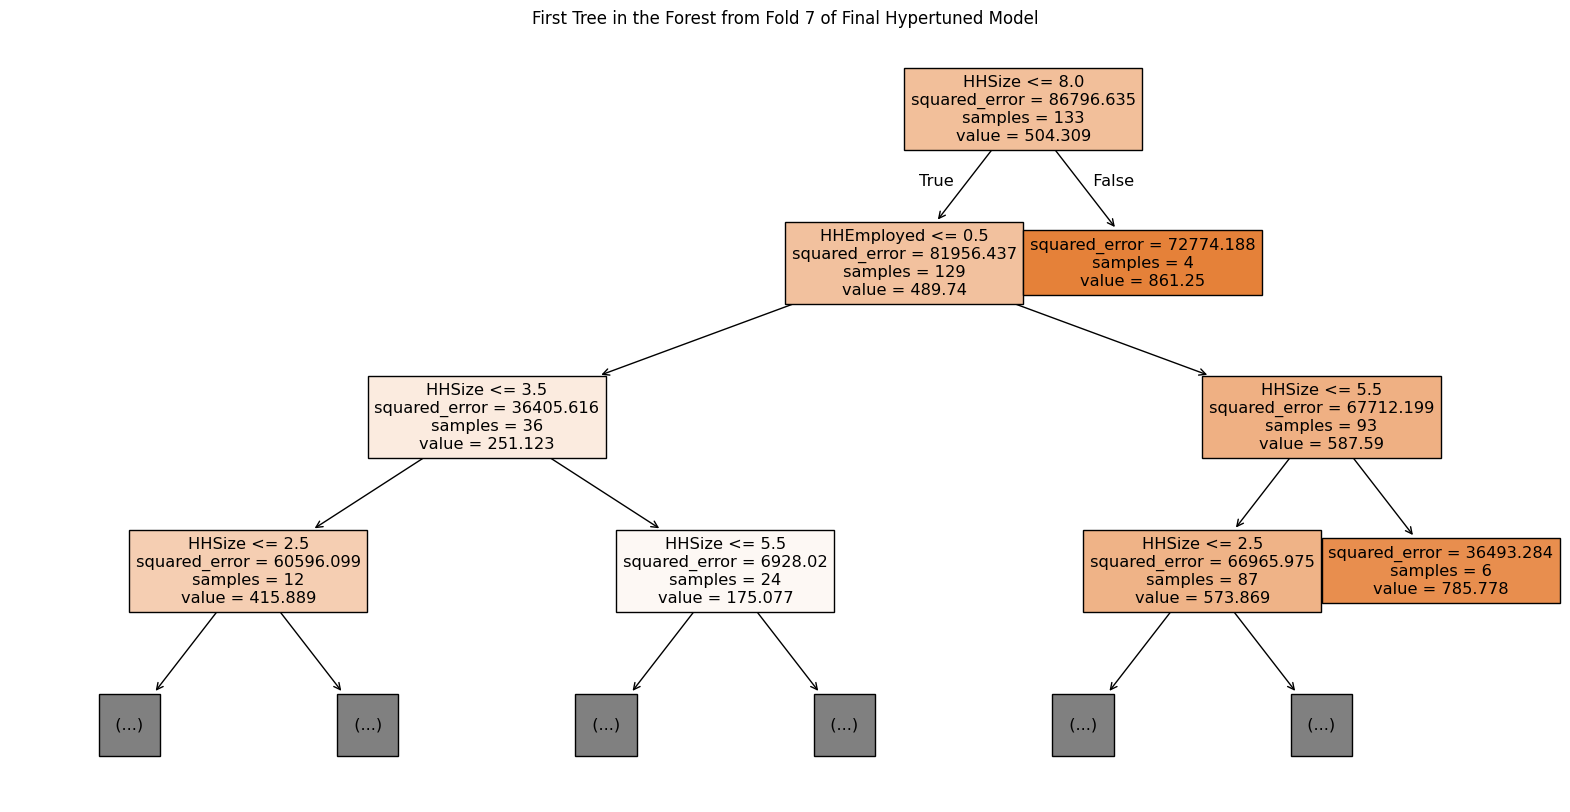

C:\Users\morel\AppData\Local\Temp\ipykernel_21620\3034712108.py:46: OptimizeWarning: Covariance of the parameters could not be estimated
  params, covariance = curve_fit(logistic_func, y_test, y_pred)


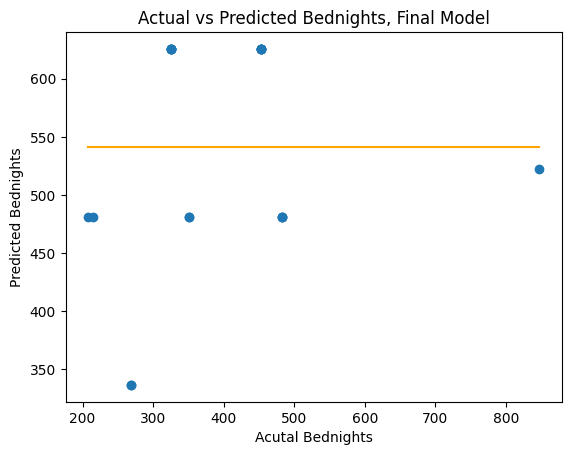

Fold 7 - MSE: 44603.9797, RMSE: 211.1965, R^2: -1.4077
Fold 8 best params: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 200}


<Figure size 640x480 with 0 Axes>

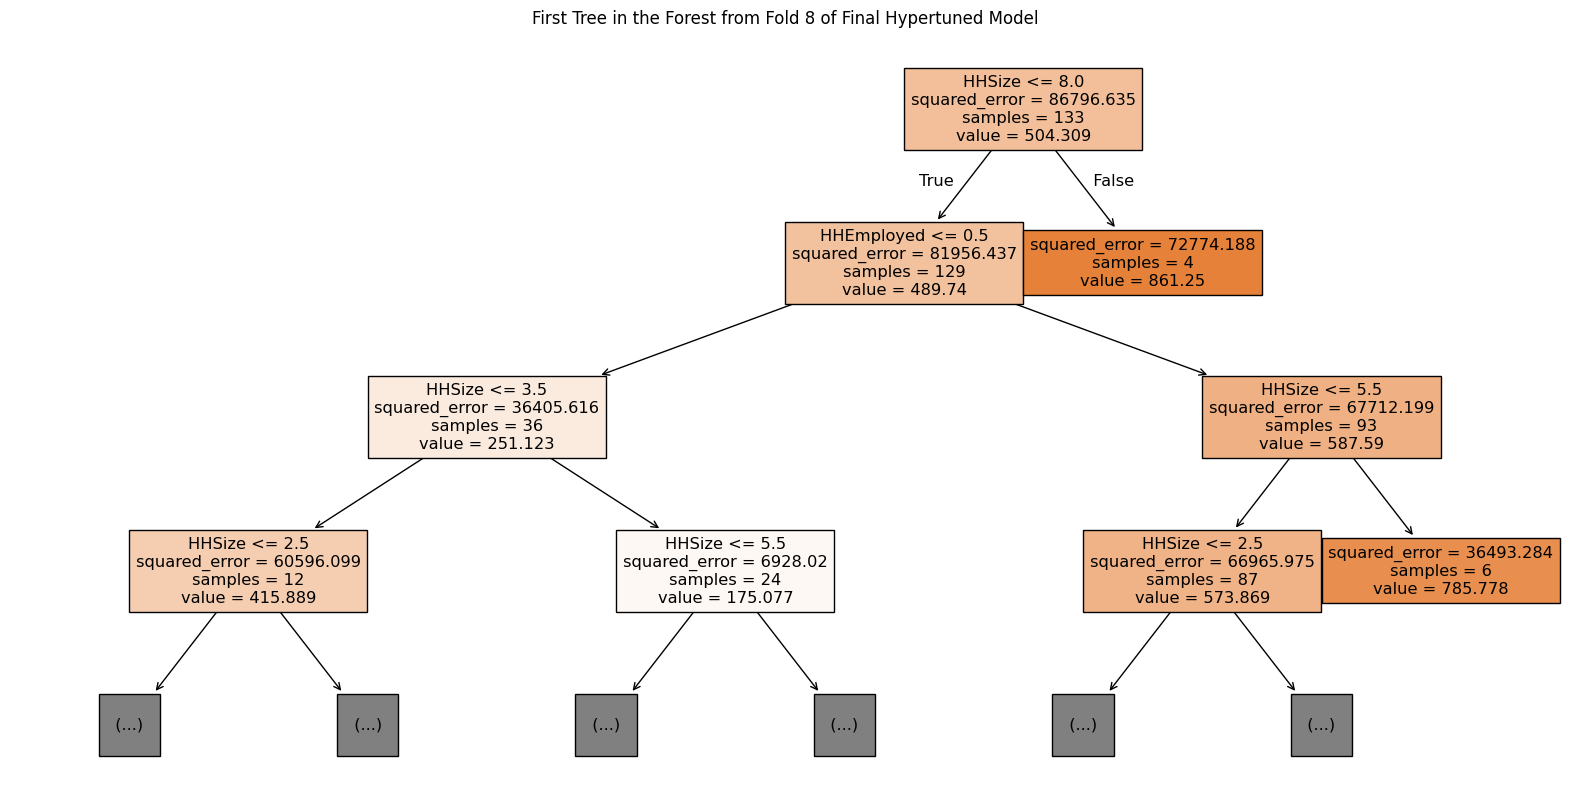

C:\Users\morel\AppData\Local\Temp\ipykernel_21620\3034712108.py:46: OptimizeWarning: Covariance of the parameters could not be estimated
  params, covariance = curve_fit(logistic_func, y_test, y_pred)


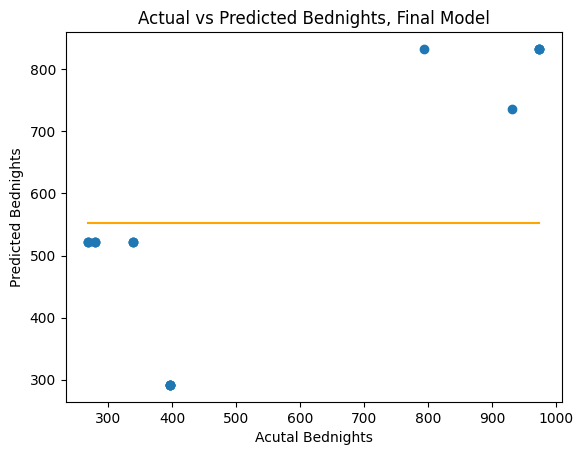

Fold 8 - MSE: 32077.1479, RMSE: 179.1009, R^2: 0.5992
Fold 9 best params: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 200}


<Figure size 640x480 with 0 Axes>

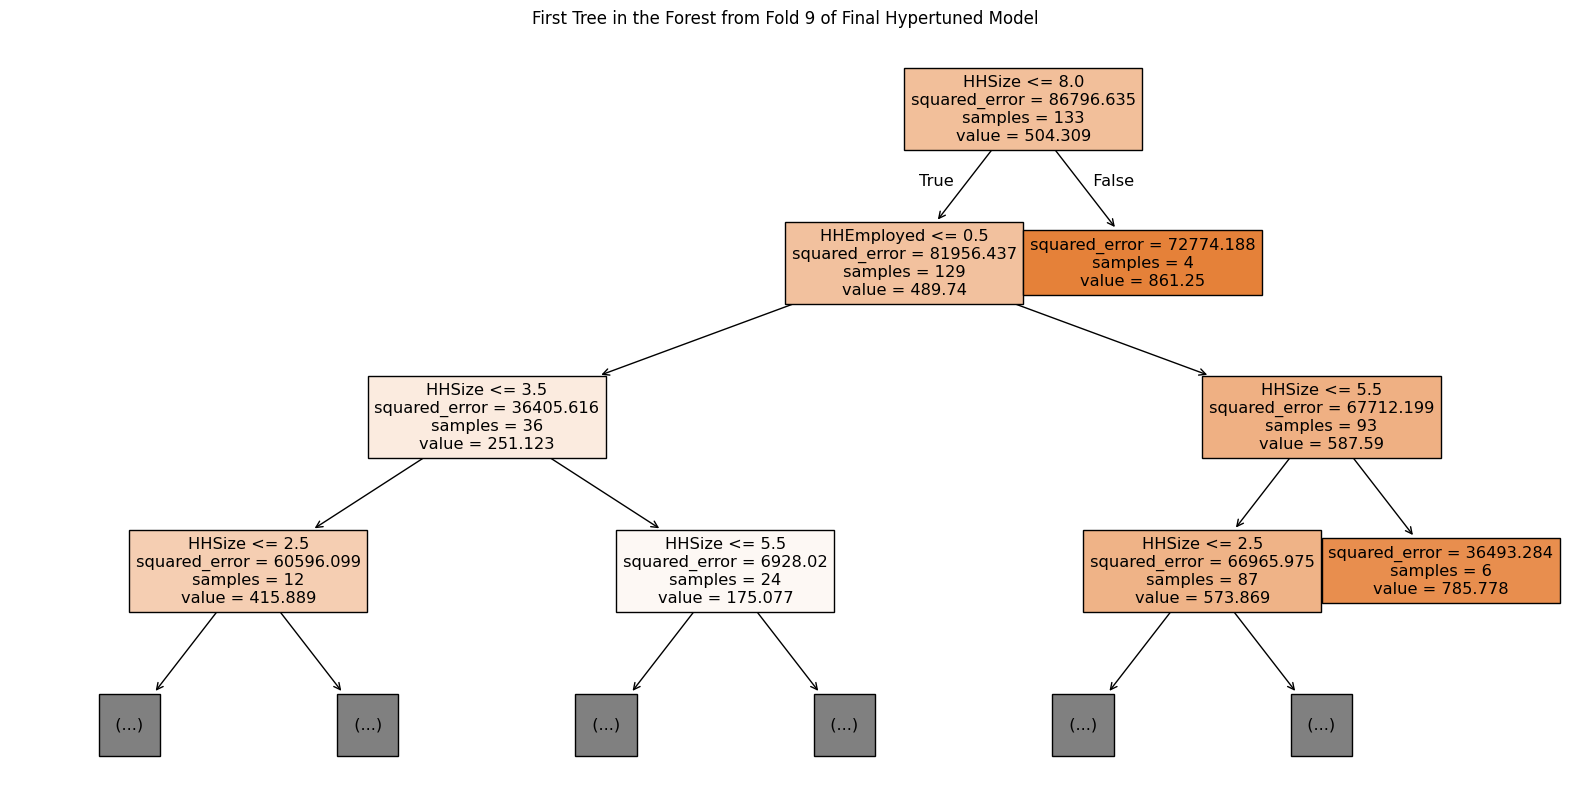

C:\Users\morel\AppData\Local\Temp\ipykernel_21620\3034712108.py:46: OptimizeWarning: Covariance of the parameters could not be estimated
  params, covariance = curve_fit(logistic_func, y_test, y_pred)


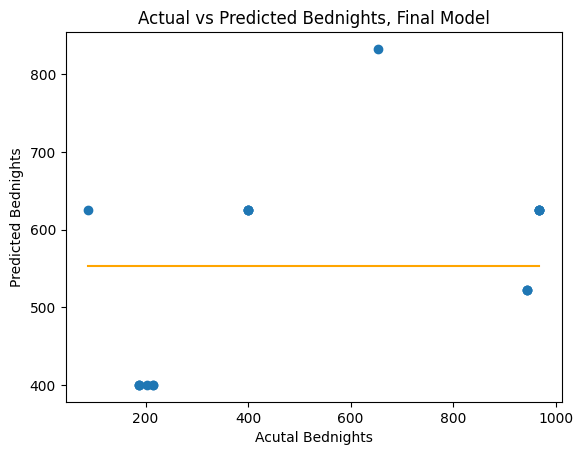

Fold 9 - MSE: 94513.9098, RMSE: 307.4311, R^2: 0.2105
Fold 10 best params: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 200}


<Figure size 640x480 with 0 Axes>

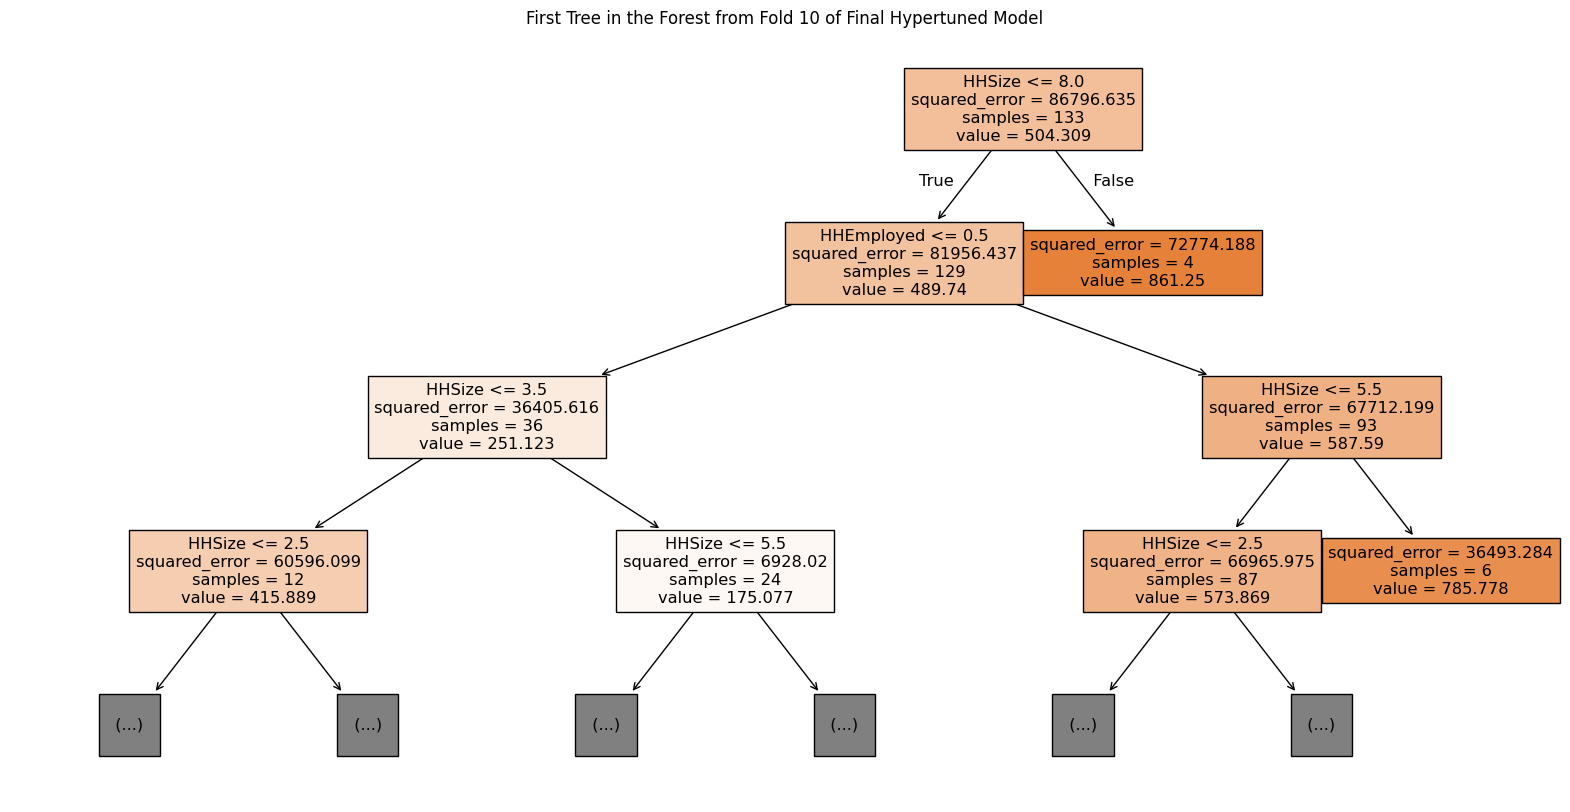

C:\Users\morel\AppData\Local\Temp\ipykernel_21620\3034712108.py:46: OptimizeWarning: Covariance of the parameters could not be estimated
  params, covariance = curve_fit(logistic_func, y_test, y_pred)


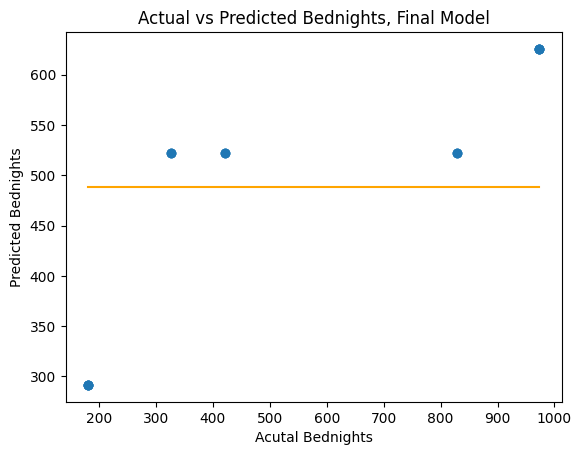

Fold 10 - MSE: 57489.4009, RMSE: 239.7695, R^2: 0.4562


<Figure size 640x480 with 0 Axes>

In [19]:
##Improve Final Model: predict bednights. train final model. hypertune final model.
x_best = x[best_features]

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2,5],
    'max_features': ['sqrt','log2']
}

for fold, (train_idx, test_idx) in enumerate(gkf.split(x_best, y, groups)):
    x_train, x_test = x_best.iloc[train_idx], x_best.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx] 

    grid = GridSearchCV(
        estimator=RandomForestRegressor(random_state=42),
        param_grid=param_grid,
        scoring='r2',
        cv=3,
        n_jobs=-1,
        verbose=0
    )
    grid.fit(x_best, y)
    best_model = grid.best_estimator_
    print(f"Fold {fold+1} best params: {grid.best_params_}")

    ##predict bednights
    y_pred = best_model.predict(x_test)
    first_tree = best_model.estimators_[0]
    feature_names = x_best.columns

    ##show tree
    plt.figure(figsize=(20, 10))
    plot_tree(first_tree,
             feature_names=feature_names,
             filled=True,
             rounded=False,
             max_depth=3)
    plt.title(f'First Tree in the Forest from Fold {fold+1} of Final Hypertuned Model')
    plt.show()
    plt.clf()

    ##compare acutal and predicted bednights: fitness. logistic best fit
    def logistic_func(x, a, b, c, d):
        return a / (1.0 + np.exp(-c * (x - d))) + b
    params, covariance = curve_fit(logistic_func, y_test, y_pred)
    a, b, c, d = params
    x_fit = np.linspace(min(y_test), max(y_test), 100)
    y_fit = logistic_func(x_fit, a, b, c, d)
    
    plt.scatter(y_test, y_pred)
    a, b = np.polyfit(y_test, y_pred, 1)
    plt.plot(x_fit, y_fit, color='orange')
    plt.xlabel('Acutal Bednights')
    plt.ylabel('Predicted Bednights')
    plt.title('Actual vs Predicted Bednights, Final Model')
    plt.show()
    plt.clf()

    ##Evaluate
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    print(f'Fold {fold+1} - MSE: {mse:.4f}, RMSE: {rmse:.4f}, R^2: {r2:.4f}')

Outcome: the model has improved over the original Forest and over Linear Regression. Splitting household size into big and small bins and getting dummy variables doesn't improve model. Attempting hypertuning: contributed to improvements in model.